In [ ]:
"""
"Створення моделі машинного навчання для прогнозування ціни на житло (квартира, таунхаус, будинок) в місті Рівне"

Джерела:

realtor.ua
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
dom.ria.com
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
forbes.ua
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
M2Bomber
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

Примітки:

Вартість в доларах із-за нестабільності курса валют

Висновок:

Під час воєнних дій на території України спостерігалося істотне зниження обсягів будівництва житлових та 
комерційних споруд. Втім, місто Рівне виявилося винятком із загальної тенденції. У цьому регіоні 
зареєстровано зростання вартості нерухомості та кількості пропозицій на ринку. Проте, попри збільшення 
пропозиції, попит залишається в стагнації (стабільним), що може бути обумовлено значною кількістю переселенців
та громадян які використовують державну програму єОселя, а також громадян які мають фінансові можливості 
для здійснення інвестицій у нерухомість (Люди зі сходу та центру частіше купують нерухомість в даному місті).

Спрогнозувати ціни на нерухомість більш точно можливо тільки за стабілізацією економічної ситуації в країні, та 
збором додаткових даних...

"Будівництво скоротилоcя майже всюди, попит обвалився, але ціни не падають". 
Дослідження ринку нерухомості під час війни від Ernst & Young. 

"""

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data1.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [3]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Ціна в $/м²  \
0                             2                       1         1644   
1                             2                       1         1500   
2                             2                       2         1656   
3                             2                       2         1417   
4                             2                       1         1500   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  Вартість  \
0                             1                          4     96996   
1                             1       

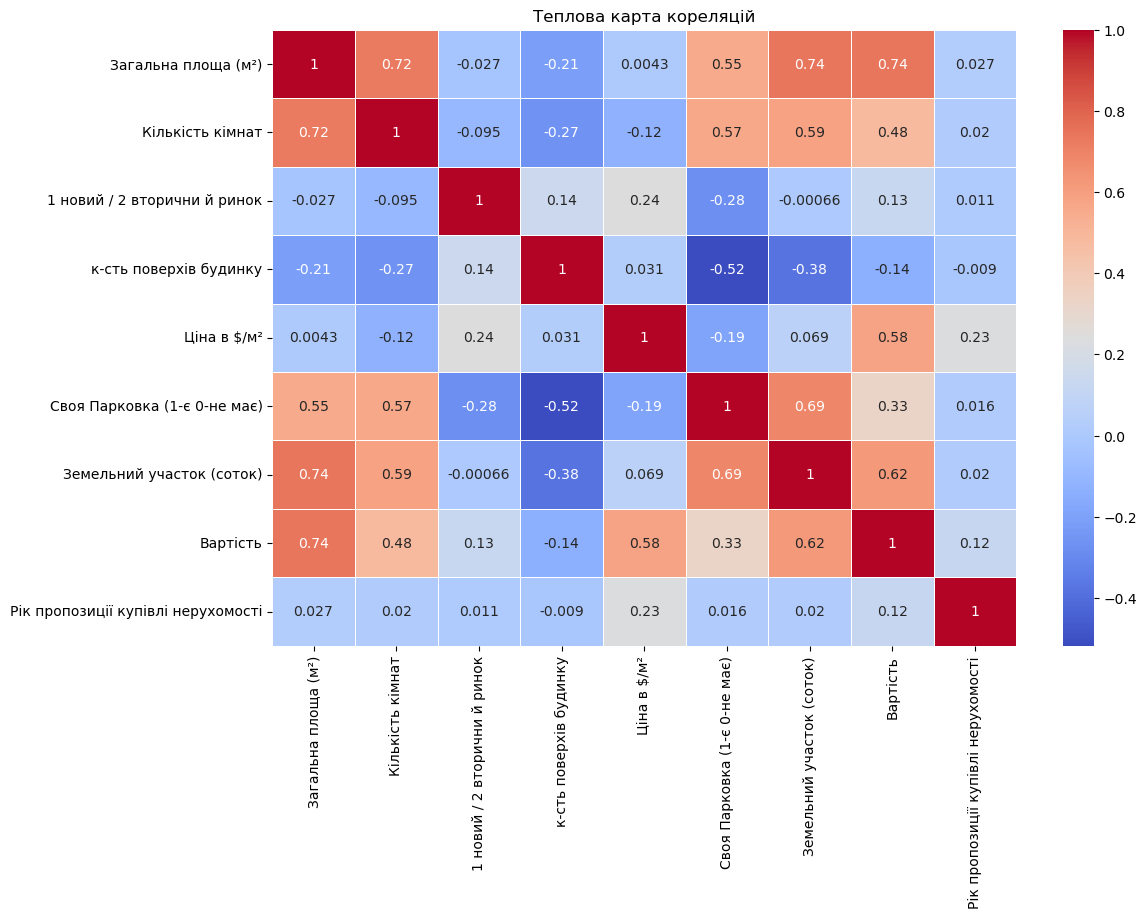

In [4]:
# приховати попередження
warnings.filterwarnings("ignore")

# візуалізація залежностей між даними датасету
"""
Позитивна кореляція (значення більше 0) вказує що, якщо одна змінна зростає, інша також зростає.
Негативна кореляція (значення менше 0) означає, що, якщо одна змінна зростає, інша зменшується. Тобто обидві змінні рухаються в протилежних напрямках.
Відсутність кореляції (значення близьке до 0) означає, що між змінними немає сильного статистичного зв'язку.
"""
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()

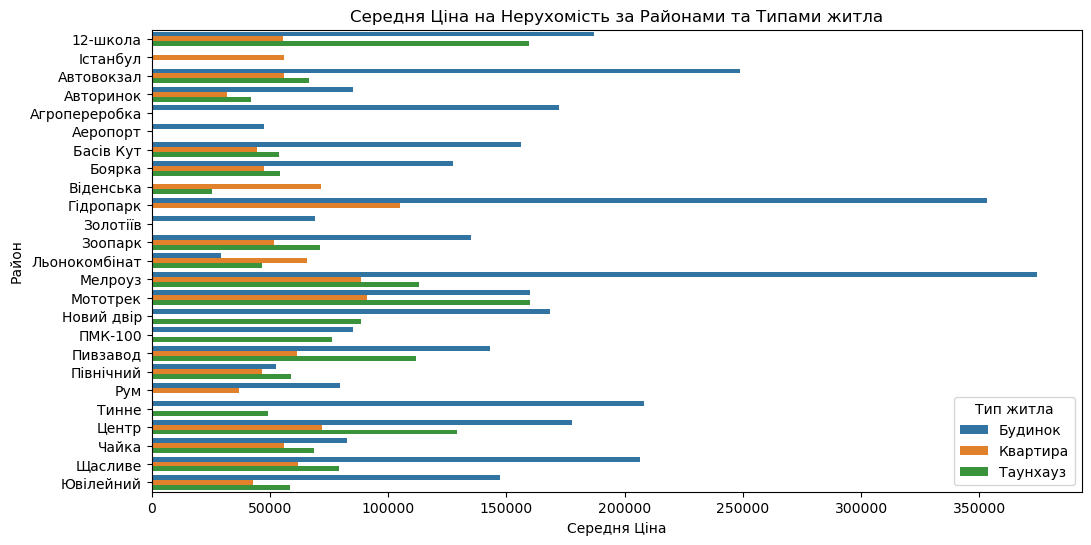

In [5]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [6]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Район                               2314 non-null   object
 1   Тип житла                           2314 non-null   object
 2   Загальна площа (м²)                 2314 non-null   int64 
 3   Кількість кімнат                    2314 non-null   int64 
 4   1 новий / 2 вторични й ринок        2314 non-null   int64 
 5   к-сть поверхів будинку              2314 non-null   int64 
 6   Ціна в $/м²                         2314 non-null   int64 
 7   Своя Парковка (1-є 0-не має)        2314 non-null   int64 
 8   Земельний участок (соток)           2314 non-null   int64 
 9   Вартість                            2314 non-null   int64 
 10  Рік пропозиції купівлі нерухомості  2314 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 199.0+ KB
None


In [7]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


Індекси викидів:
(array([   3,    6,   30,   33,  111,  139,  164,  276,  277,  297,  298,
        536,  539,  542,  545,  588,  622,  655,  872,  873,  881,  882,
        889,  898,  946,  972, 1353, 1432, 1490, 1712, 1713, 1774, 1778,
       1838, 1892, 1933, 1987, 1988, 1989, 2075, 2084, 2085, 2086, 2170,
       2177, 2178, 2262, 2269, 2270]),)


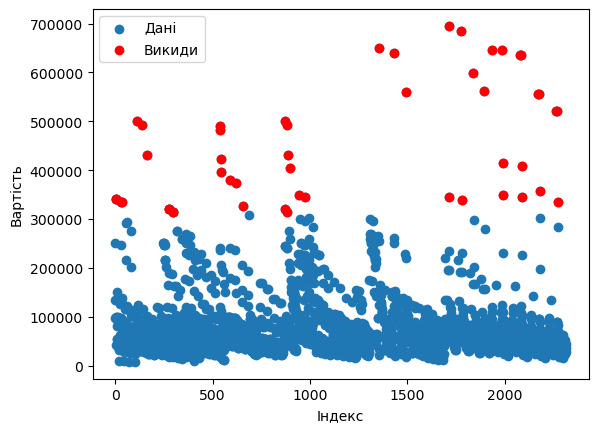

In [41]:
# шукаємо викиди в даних вартості
column_name = 'Вартість'

# рівень для Z-оцінки (в документації всі ставлять 3)
threshold = 3

z_scores = stats.zscore(df[column_name])

# індекси викидів
outliers_indices = np.where(np.abs(z_scores) > threshold)

# вивожу індекси викидів
print("Індекси викидів:")
print(outliers_indices)

# графік
plt.scatter(df.index, df[column_name], label='Дані')
plt.scatter(outliers_indices, df.loc[outliers_indices][column_name], color='red', label='Викиди')
plt.xlabel('Індекс')
plt.ylabel(column_name)
plt.legend()
plt.show()

In [32]:
# Видаляємо рядки з викидами із DataFrame
df_cleaned = df.drop(outliers_indices[0])

In [10]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляції

columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)', '1 новий / 2 вторични й ринок', 'Рік пропозиції купівлі нерухомості']
df = df.drop(columns=columns_to_drop, axis=1)

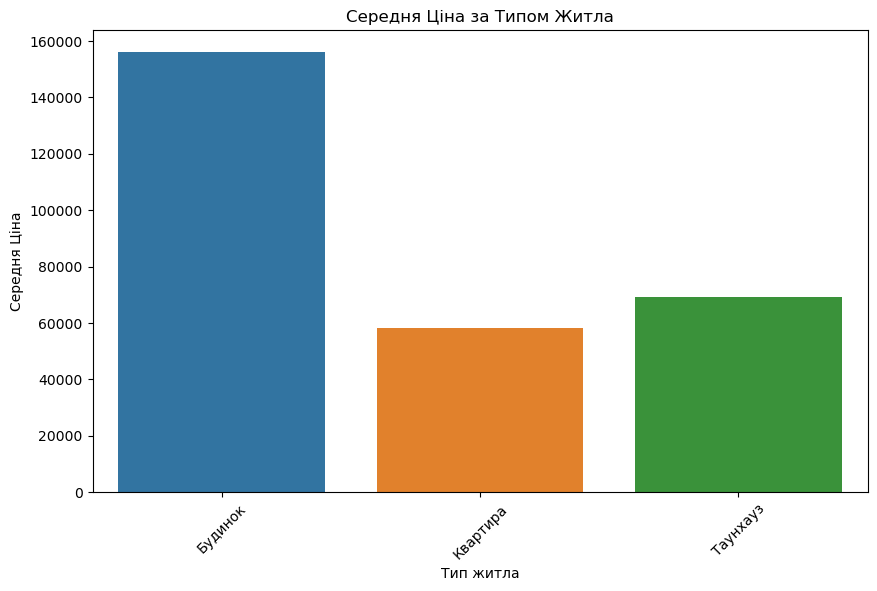

In [11]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


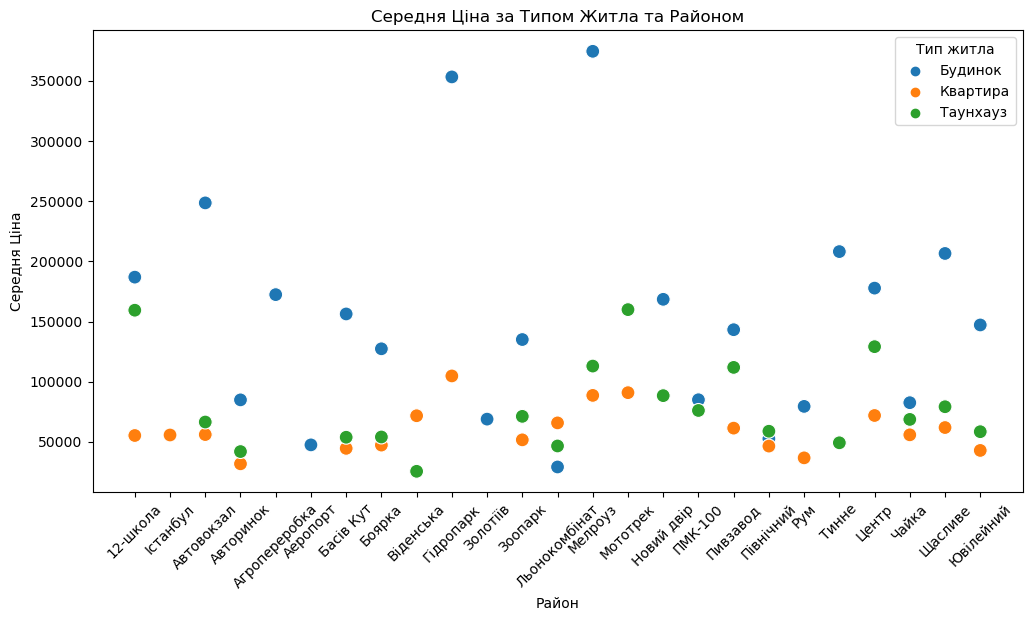

In [12]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

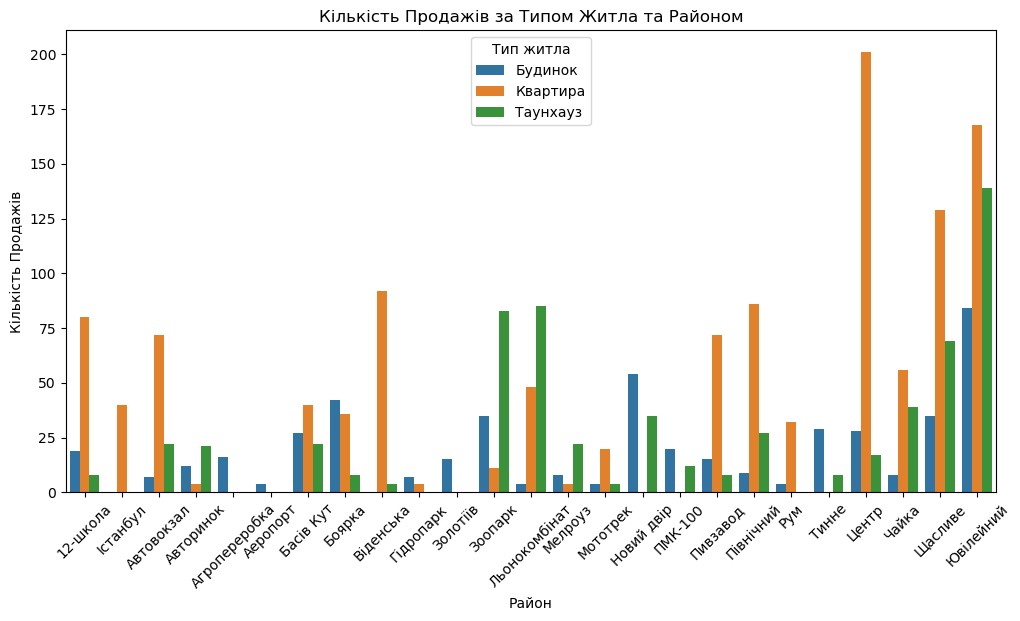

In [13]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [14]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перегляньте оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,Ціна в $/м²,Земельний участок (соток),Вартість
0,12-школа,3,59,3,1644,4,96996
1,12-школа,3,90,2,1500,6,135000
2,12-школа,2,151,3,1656,4,250056
3,12-школа,3,240,4,1417,7,340080
4,12-школа,3,90,2,1500,6,135000


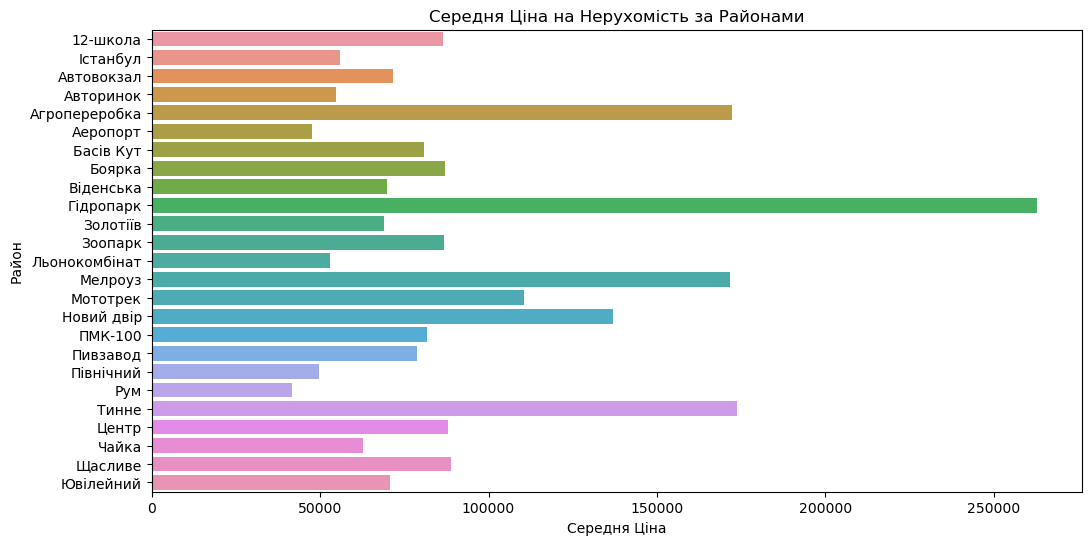

In [15]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [16]:
# Переводимо категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
df = pd.get_dummies(df, columns=['Район'])

In [17]:
# тепер пробуємо створити та навчати модель машиного навчання для задачі регресії та подивимось на результати

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.9040509308037916
Mean Squared Error (MSE) of Linear Regression: 616820345.9598919


In [19]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.99799432861636
Mean Squared Error (MSE) of Random Forest: 12893704.202683162


In [20]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.9922396508956985
Mean Squared Error (MSE) of Gradient Boosting: 49888354.93022085


In [21]:
# тепер пробуємо створити та навчати модель нейроної мережі для задачі регресії та подивимось на результати

In [22]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Створення та компіляція (модель створена за допомогою класу Sequential тобто шари попорядку)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Навчання моделі (я підберав різну кількість епох, найкращі результати при 10 тис. так й )
model.fit(X_train, y_train, epochs=9900, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/9900
47/47 [==============================] - 0s 938us/step - loss: 50718.0000 - val_loss: 2519202.5000
Epoch 2/9900
47/47 [==============================] - 0s 633us/step - loss: 52221.1836 - val_loss: 2446071.2500
Epoch 3/9900
47/47 [==============================] - 0s 616us/step - loss: 53326.6172 - val_loss: 2354784.7500
Epoch 4/9900
47/47 [==============================] - 0s 617us/step - loss: 57642.9453 - val_loss: 2483724.0000
Epoch 5/9900
47/47 [==============================] - 0s 576us/step - loss: 54821.1562 - val_loss: 2465870.0000
Epoch 6/9900
47/47 [==============================] - 0s 604us/step - loss: 47913.0859 - val_loss: 2478774.2500
Epoch 7/9900
47/47 [==============================] - 0s 611us/step - loss: 50252.6094 - val_loss: 2469291.7500
Epoch 8/9900
47/47 [==============================] - 0s 602us/step - loss: 47983.0000 - val_loss: 2574001.2500
Epoch 9/9900
47/47 [==============================] - 0s 614us/step - loss: 56733.8711 - val_loss: 24942

47/47 [==============================] - 0s 630us/step - loss: 54930.8867 - val_loss: 2585544.5000
Epoch 74/9900
47/47 [==============================] - 0s 604us/step - loss: 60249.9883 - val_loss: 2560324.7500
Epoch 75/9900
47/47 [==============================] - 0s 602us/step - loss: 61715.9062 - val_loss: 2564526.5000
Epoch 76/9900
47/47 [==============================] - 0s 620us/step - loss: 56176.5391 - val_loss: 2686903.0000
Epoch 77/9900
47/47 [==============================] - 0s 614us/step - loss: 55948.0664 - val_loss: 2524532.5000
Epoch 78/9900
47/47 [==============================] - 0s 580us/step - loss: 64222.9297 - val_loss: 2501351.7500
Epoch 79/9900
47/47 [==============================] - 0s 593us/step - loss: 58993.7930 - val_loss: 2552114.2500
Epoch 80/9900
47/47 [==============================] - 0s 607us/step - loss: 50482.4062 - val_loss: 2517526.0000
Epoch 81/9900
47/47 [==============================] - 0s 616us/step - loss: 50138.2227 - val_loss: 2516871.75

47/47 [==============================] - 0s 597us/step - loss: 48763.4961 - val_loss: 2553724.5000
Epoch 146/9900
47/47 [==============================] - 0s 638us/step - loss: 50319.9609 - val_loss: 2544439.0000
Epoch 147/9900
47/47 [==============================] - 0s 598us/step - loss: 56742.2500 - val_loss: 2370235.7500
Epoch 148/9900
47/47 [==============================] - 0s 587us/step - loss: 55151.2695 - val_loss: 2483129.5000
Epoch 149/9900
47/47 [==============================] - 0s 590us/step - loss: 51238.9688 - val_loss: 2523014.0000
Epoch 150/9900
47/47 [==============================] - 0s 591us/step - loss: 56470.9883 - val_loss: 2474085.5000
Epoch 151/9900
47/47 [==============================] - 0s 600us/step - loss: 46679.3789 - val_loss: 2405548.7500
Epoch 152/9900
47/47 [==============================] - 0s 606us/step - loss: 50891.1562 - val_loss: 2506190.7500
Epoch 153/9900
47/47 [==============================] - 0s 604us/step - loss: 52839.6719 - val_loss: 26

Epoch 217/9900
47/47 [==============================] - 0s 621us/step - loss: 51353.8711 - val_loss: 2527913.0000
Epoch 218/9900
47/47 [==============================] - 0s 601us/step - loss: 48972.8984 - val_loss: 2378457.2500
Epoch 219/9900
47/47 [==============================] - 0s 601us/step - loss: 58594.4648 - val_loss: 2531902.7500
Epoch 220/9900
47/47 [==============================] - 0s 607us/step - loss: 47392.4688 - val_loss: 2579441.7500
Epoch 221/9900
47/47 [==============================] - 0s 607us/step - loss: 46149.7930 - val_loss: 2554691.7500
Epoch 222/9900
47/47 [==============================] - 0s 610us/step - loss: 44414.6953 - val_loss: 2387147.7500
Epoch 223/9900
47/47 [==============================] - 0s 606us/step - loss: 51294.0430 - val_loss: 2502382.7500
Epoch 224/9900
47/47 [==============================] - 0s 600us/step - loss: 51239.0039 - val_loss: 2411283.5000
Epoch 225/9900
47/47 [==============================] - 0s 626us/step - loss: 47475.2227

Epoch 289/9900
47/47 [==============================] - 0s 597us/step - loss: 49846.9141 - val_loss: 2452781.2500
Epoch 290/9900
47/47 [==============================] - 0s 617us/step - loss: 49178.5508 - val_loss: 2470849.2500
Epoch 291/9900
47/47 [==============================] - 0s 617us/step - loss: 53635.5117 - val_loss: 2420891.0000
Epoch 292/9900
47/47 [==============================] - 0s 607us/step - loss: 56495.2852 - val_loss: 2440976.5000
Epoch 293/9900
47/47 [==============================] - 0s 605us/step - loss: 61566.4414 - val_loss: 2485256.0000
Epoch 294/9900
47/47 [==============================] - 0s 601us/step - loss: 50934.9453 - val_loss: 2376808.0000
Epoch 295/9900
47/47 [==============================] - 0s 610us/step - loss: 48727.2500 - val_loss: 2476877.0000
Epoch 296/9900
47/47 [==============================] - 0s 598us/step - loss: 44647.0742 - val_loss: 2548606.2500
Epoch 297/9900
47/47 [==============================] - 0s 591us/step - loss: 50867.5742

Epoch 361/9900
47/47 [==============================] - 0s 607us/step - loss: 50821.0312 - val_loss: 2365385.2500
Epoch 362/9900
47/47 [==============================] - 0s 612us/step - loss: 47334.6289 - val_loss: 2409045.5000
Epoch 363/9900
47/47 [==============================] - 0s 607us/step - loss: 45631.1523 - val_loss: 2591939.2500
Epoch 364/9900
47/47 [==============================] - 0s 614us/step - loss: 46166.9688 - val_loss: 2547404.5000
Epoch 365/9900
47/47 [==============================] - 0s 596us/step - loss: 52991.7227 - val_loss: 2655908.5000
Epoch 366/9900
47/47 [==============================] - 0s 600us/step - loss: 49285.1719 - val_loss: 2561923.5000
Epoch 367/9900
47/47 [==============================] - 0s 600us/step - loss: 48410.1016 - val_loss: 2544085.7500
Epoch 368/9900
47/47 [==============================] - 0s 610us/step - loss: 51486.4062 - val_loss: 2444474.2500
Epoch 369/9900
47/47 [==============================] - 0s 594us/step - loss: 50675.7227

Epoch 433/9900
47/47 [==============================] - 0s 611us/step - loss: 47712.2266 - val_loss: 2549380.2500
Epoch 434/9900
47/47 [==============================] - 0s 599us/step - loss: 46510.6719 - val_loss: 2488565.2500
Epoch 435/9900
47/47 [==============================] - 0s 612us/step - loss: 48988.5781 - val_loss: 2446762.0000
Epoch 436/9900
47/47 [==============================] - 0s 603us/step - loss: 53979.3828 - val_loss: 2442544.0000
Epoch 437/9900
47/47 [==============================] - 0s 604us/step - loss: 50826.7344 - val_loss: 2396569.5000
Epoch 438/9900
47/47 [==============================] - 0s 617us/step - loss: 45112.4258 - val_loss: 2492994.5000
Epoch 439/9900
47/47 [==============================] - 0s 609us/step - loss: 45166.4805 - val_loss: 2414856.7500
Epoch 440/9900
47/47 [==============================] - 0s 626us/step - loss: 50446.8438 - val_loss: 2486756.5000
Epoch 441/9900
47/47 [==============================] - 0s 612us/step - loss: 50091.8906

Epoch 505/9900
47/47 [==============================] - 0s 614us/step - loss: 45239.2070 - val_loss: 2438508.0000
Epoch 506/9900
47/47 [==============================] - 0s 608us/step - loss: 45956.1523 - val_loss: 2554348.2500
Epoch 507/9900
47/47 [==============================] - 0s 605us/step - loss: 46763.3008 - val_loss: 2534787.7500
Epoch 508/9900
47/47 [==============================] - 0s 601us/step - loss: 56211.8867 - val_loss: 2570068.7500
Epoch 509/9900
47/47 [==============================] - 0s 608us/step - loss: 51318.8906 - val_loss: 2739053.2500
Epoch 510/9900
47/47 [==============================] - 0s 590us/step - loss: 50663.5234 - val_loss: 2442560.2500
Epoch 511/9900
47/47 [==============================] - 0s 606us/step - loss: 47564.6016 - val_loss: 2411955.0000
Epoch 512/9900
47/47 [==============================] - 0s 610us/step - loss: 52426.6484 - val_loss: 2513207.2500
Epoch 513/9900
47/47 [==============================] - 0s 621us/step - loss: 50965.2930

Epoch 577/9900
47/47 [==============================] - 0s 608us/step - loss: 53182.2930 - val_loss: 2496637.0000
Epoch 578/9900
47/47 [==============================] - 0s 604us/step - loss: 51313.7773 - val_loss: 2583864.0000
Epoch 579/9900
47/47 [==============================] - 0s 622us/step - loss: 52819.7188 - val_loss: 2509086.2500
Epoch 580/9900
47/47 [==============================] - 0s 590us/step - loss: 51091.9414 - val_loss: 2387627.7500
Epoch 581/9900
47/47 [==============================] - 0s 600us/step - loss: 46235.1289 - val_loss: 2586324.0000
Epoch 582/9900
47/47 [==============================] - 0s 618us/step - loss: 47174.6758 - val_loss: 2623494.0000
Epoch 583/9900
47/47 [==============================] - 0s 611us/step - loss: 53887.2930 - val_loss: 2566789.2500
Epoch 584/9900
47/47 [==============================] - 0s 613us/step - loss: 48881.0156 - val_loss: 2516471.7500
Epoch 585/9900
47/47 [==============================] - 0s 599us/step - loss: 47394.7930

Epoch 649/9900
47/47 [==============================] - 0s 611us/step - loss: 44903.7266 - val_loss: 2433630.2500
Epoch 650/9900
47/47 [==============================] - 0s 607us/step - loss: 43575.9922 - val_loss: 2495057.5000
Epoch 651/9900
47/47 [==============================] - 0s 599us/step - loss: 44745.2344 - val_loss: 2378288.2500
Epoch 652/9900
47/47 [==============================] - 0s 610us/step - loss: 44505.8125 - val_loss: 2538939.2500
Epoch 653/9900
47/47 [==============================] - 0s 617us/step - loss: 46420.9023 - val_loss: 2495544.7500
Epoch 654/9900
47/47 [==============================] - 0s 600us/step - loss: 47014.5117 - val_loss: 2398434.5000
Epoch 655/9900
47/47 [==============================] - 0s 605us/step - loss: 49630.0742 - val_loss: 2442603.7500
Epoch 656/9900
47/47 [==============================] - 0s 606us/step - loss: 48386.1641 - val_loss: 2346000.0000
Epoch 657/9900
47/47 [==============================] - 0s 620us/step - loss: 49398.7344

Epoch 721/9900
47/47 [==============================] - 0s 599us/step - loss: 47866.3398 - val_loss: 2456782.0000
Epoch 722/9900
47/47 [==============================] - 0s 611us/step - loss: 57831.7656 - val_loss: 2395820.7500
Epoch 723/9900
47/47 [==============================] - 0s 617us/step - loss: 51277.0273 - val_loss: 2416734.7500
Epoch 724/9900
47/47 [==============================] - 0s 607us/step - loss: 48949.5508 - val_loss: 2500112.2500
Epoch 725/9900
47/47 [==============================] - 0s 621us/step - loss: 51049.4219 - val_loss: 2493432.5000
Epoch 726/9900
47/47 [==============================] - 0s 604us/step - loss: 59506.8555 - val_loss: 2396363.5000
Epoch 727/9900
47/47 [==============================] - 0s 613us/step - loss: 56655.0664 - val_loss: 2465895.7500
Epoch 728/9900
47/47 [==============================] - 0s 595us/step - loss: 44689.2773 - val_loss: 2427626.5000
Epoch 729/9900
47/47 [==============================] - 0s 609us/step - loss: 43714.7383

Epoch 793/9900
47/47 [==============================] - 0s 613us/step - loss: 48065.2422 - val_loss: 2461269.2500
Epoch 794/9900
47/47 [==============================] - 0s 583us/step - loss: 49951.7188 - val_loss: 2383109.0000
Epoch 795/9900
47/47 [==============================] - 0s 621us/step - loss: 56502.9453 - val_loss: 2463664.7500
Epoch 796/9900
47/47 [==============================] - 0s 604us/step - loss: 47896.8203 - val_loss: 2432281.5000
Epoch 797/9900
47/47 [==============================] - 0s 614us/step - loss: 49199.1289 - val_loss: 2412722.2500
Epoch 798/9900
47/47 [==============================] - 0s 605us/step - loss: 46565.9297 - val_loss: 2435146.2500
Epoch 799/9900
47/47 [==============================] - 0s 627us/step - loss: 49223.1836 - val_loss: 2521426.7500
Epoch 800/9900
47/47 [==============================] - 0s 606us/step - loss: 62068.3516 - val_loss: 2369489.0000
Epoch 801/9900
47/47 [==============================] - 0s 599us/step - loss: 47620.4766

Epoch 865/9900
47/47 [==============================] - 0s 619us/step - loss: 46489.4258 - val_loss: 2508050.7500
Epoch 866/9900
47/47 [==============================] - 0s 626us/step - loss: 50476.9023 - val_loss: 2577581.7500
Epoch 867/9900
47/47 [==============================] - 0s 618us/step - loss: 55312.3984 - val_loss: 2396238.7500
Epoch 868/9900
47/47 [==============================] - 0s 604us/step - loss: 49880.3008 - val_loss: 2427162.0000
Epoch 869/9900
47/47 [==============================] - 0s 630us/step - loss: 46771.0117 - val_loss: 2373878.2500
Epoch 870/9900
47/47 [==============================] - 0s 611us/step - loss: 46938.0938 - val_loss: 2383259.0000
Epoch 871/9900
47/47 [==============================] - 0s 615us/step - loss: 73374.6016 - val_loss: 2368162.2500
Epoch 872/9900
47/47 [==============================] - 0s 606us/step - loss: 46090.2695 - val_loss: 2323997.2500
Epoch 873/9900
47/47 [==============================] - 0s 608us/step - loss: 47237.0977

Epoch 937/9900
47/47 [==============================] - 0s 631us/step - loss: 51636.9023 - val_loss: 2483183.5000
Epoch 938/9900
47/47 [==============================] - 0s 619us/step - loss: 49393.3789 - val_loss: 2425475.0000
Epoch 939/9900
47/47 [==============================] - 0s 614us/step - loss: 44635.3242 - val_loss: 2331415.5000
Epoch 940/9900
47/47 [==============================] - 0s 606us/step - loss: 47716.5508 - val_loss: 2375795.0000
Epoch 941/9900
47/47 [==============================] - 0s 616us/step - loss: 60570.8477 - val_loss: 2491887.5000
Epoch 942/9900
47/47 [==============================] - 0s 607us/step - loss: 51955.9258 - val_loss: 2398432.5000
Epoch 943/9900
47/47 [==============================] - 0s 589us/step - loss: 45349.5391 - val_loss: 2449010.2500
Epoch 944/9900
47/47 [==============================] - 0s 610us/step - loss: 43255.3125 - val_loss: 2528127.7500
Epoch 945/9900
47/47 [==============================] - 0s 618us/step - loss: 44083.6367

Epoch 1009/9900
47/47 [==============================] - 0s 609us/step - loss: 51892.0586 - val_loss: 2573935.5000
Epoch 1010/9900
47/47 [==============================] - 0s 619us/step - loss: 51515.6641 - val_loss: 2396598.2500
Epoch 1011/9900
47/47 [==============================] - 0s 596us/step - loss: 68891.1484 - val_loss: 2410702.2500
Epoch 1012/9900
47/47 [==============================] - 0s 615us/step - loss: 48248.7891 - val_loss: 2562838.7500
Epoch 1013/9900
47/47 [==============================] - 0s 626us/step - loss: 46131.0469 - val_loss: 2384476.0000
Epoch 1014/9900
47/47 [==============================] - 0s 605us/step - loss: 43010.6641 - val_loss: 2427622.0000
Epoch 1015/9900
47/47 [==============================] - 0s 615us/step - loss: 43968.3555 - val_loss: 2423705.2500
Epoch 1016/9900
47/47 [==============================] - 0s 624us/step - loss: 42398.2422 - val_loss: 2385845.7500
Epoch 1017/9900
47/47 [==============================] - 0s 617us/step - loss: 4

47/47 [==============================] - 0s 612us/step - loss: 45211.1016 - val_loss: 2386050.5000
Epoch 1081/9900
47/47 [==============================] - 0s 627us/step - loss: 48912.1289 - val_loss: 2416986.0000
Epoch 1082/9900
47/47 [==============================] - 0s 605us/step - loss: 55266.1992 - val_loss: 2478561.2500
Epoch 1083/9900
47/47 [==============================] - 0s 633us/step - loss: 74106.7812 - val_loss: 2301778.7500
Epoch 1084/9900
47/47 [==============================] - 0s 616us/step - loss: 67760.7422 - val_loss: 2327791.2500
Epoch 1085/9900
47/47 [==============================] - 0s 628us/step - loss: 49571.6094 - val_loss: 2399098.7500
Epoch 1086/9900
47/47 [==============================] - 0s 616us/step - loss: 47053.8555 - val_loss: 2332671.2500
Epoch 1087/9900
47/47 [==============================] - 0s 606us/step - loss: 46201.4961 - val_loss: 2376818.2500
Epoch 1088/9900
47/47 [==============================] - 0s 632us/step - loss: 52785.8125 - val_

47/47 [==============================] - 0s 607us/step - loss: 51284.7305 - val_loss: 2444214.2500
Epoch 1152/9900
47/47 [==============================] - 0s 617us/step - loss: 43462.3125 - val_loss: 2525710.2500
Epoch 1153/9900
47/47 [==============================] - 0s 623us/step - loss: 42366.4062 - val_loss: 2513576.5000
Epoch 1154/9900
47/47 [==============================] - 0s 615us/step - loss: 45153.9336 - val_loss: 2452623.5000
Epoch 1155/9900
47/47 [==============================] - 0s 600us/step - loss: 45824.8438 - val_loss: 2444452.2500
Epoch 1156/9900
47/47 [==============================] - 0s 627us/step - loss: 48344.1445 - val_loss: 2331556.0000
Epoch 1157/9900
47/47 [==============================] - 0s 599us/step - loss: 48505.6094 - val_loss: 2403869.5000
Epoch 1158/9900
47/47 [==============================] - 0s 600us/step - loss: 43394.3633 - val_loss: 2470869.2500
Epoch 1159/9900
47/47 [==============================] - 0s 611us/step - loss: 43926.1758 - val_

47/47 [==============================] - 0s 621us/step - loss: 40867.3242 - val_loss: 2395748.0000
Epoch 1223/9900
47/47 [==============================] - 0s 626us/step - loss: 46553.3555 - val_loss: 2346249.2500
Epoch 1224/9900
47/47 [==============================] - 0s 617us/step - loss: 55701.1250 - val_loss: 2389553.2500
Epoch 1225/9900
47/47 [==============================] - 0s 618us/step - loss: 48987.7930 - val_loss: 2414582.0000
Epoch 1226/9900
47/47 [==============================] - 0s 615us/step - loss: 47493.9062 - val_loss: 2362488.5000
Epoch 1227/9900
47/47 [==============================] - 0s 620us/step - loss: 42956.7227 - val_loss: 2407368.0000
Epoch 1228/9900
47/47 [==============================] - 0s 616us/step - loss: 50265.0586 - val_loss: 2441247.5000
Epoch 1229/9900
47/47 [==============================] - 0s 614us/step - loss: 45798.8594 - val_loss: 2480323.0000
Epoch 1230/9900
47/47 [==============================] - 0s 596us/step - loss: 43875.4883 - val_

47/47 [==============================] - 0s 619us/step - loss: 64185.2539 - val_loss: 2505239.7500
Epoch 1294/9900
47/47 [==============================] - 0s 604us/step - loss: 52838.5117 - val_loss: 2377740.0000
Epoch 1295/9900
47/47 [==============================] - 0s 601us/step - loss: 52895.7188 - val_loss: 2468415.2500
Epoch 1296/9900
47/47 [==============================] - 0s 625us/step - loss: 50274.3125 - val_loss: 2451727.0000
Epoch 1297/9900
47/47 [==============================] - 0s 606us/step - loss: 45523.8281 - val_loss: 2438193.2500
Epoch 1298/9900
47/47 [==============================] - 0s 616us/step - loss: 43087.9961 - val_loss: 2525824.2500
Epoch 1299/9900
47/47 [==============================] - 0s 620us/step - loss: 43923.7070 - val_loss: 2477818.7500
Epoch 1300/9900
47/47 [==============================] - 0s 627us/step - loss: 44701.6406 - val_loss: 2502875.0000
Epoch 1301/9900
47/47 [==============================] - 0s 626us/step - loss: 44763.6016 - val_

47/47 [==============================] - 0s 615us/step - loss: 45439.3984 - val_loss: 2460806.2500
Epoch 1365/9900
47/47 [==============================] - 0s 618us/step - loss: 43443.1719 - val_loss: 2466441.5000
Epoch 1366/9900
47/47 [==============================] - 0s 627us/step - loss: 43740.0742 - val_loss: 2515478.0000
Epoch 1367/9900
47/47 [==============================] - 0s 604us/step - loss: 43915.0625 - val_loss: 2458735.5000
Epoch 1368/9900
47/47 [==============================] - 0s 621us/step - loss: 51995.4609 - val_loss: 2397010.0000
Epoch 1369/9900
47/47 [==============================] - 0s 618us/step - loss: 51274.7070 - val_loss: 2386095.5000
Epoch 1370/9900
47/47 [==============================] - 0s 639us/step - loss: 47497.4219 - val_loss: 2447339.0000
Epoch 1371/9900
47/47 [==============================] - 0s 626us/step - loss: 45619.3672 - val_loss: 2558952.7500
Epoch 1372/9900
47/47 [==============================] - 0s 637us/step - loss: 46218.3477 - val_

47/47 [==============================] - 0s 619us/step - loss: 54263.9570 - val_loss: 2403943.2500
Epoch 1436/9900
47/47 [==============================] - 0s 603us/step - loss: 49811.5391 - val_loss: 2383105.2500
Epoch 1437/9900
47/47 [==============================] - 0s 602us/step - loss: 43066.3359 - val_loss: 2443462.5000
Epoch 1438/9900
47/47 [==============================] - 0s 617us/step - loss: 46324.1445 - val_loss: 2463916.2500
Epoch 1439/9900
47/47 [==============================] - 0s 623us/step - loss: 43936.3750 - val_loss: 2435425.7500
Epoch 1440/9900
47/47 [==============================] - 0s 629us/step - loss: 45422.4258 - val_loss: 2484053.5000
Epoch 1441/9900
47/47 [==============================] - 0s 605us/step - loss: 43538.3359 - val_loss: 2456818.2500
Epoch 1442/9900
47/47 [==============================] - 0s 615us/step - loss: 48875.0117 - val_loss: 2656053.5000
Epoch 1443/9900
47/47 [==============================] - 0s 633us/step - loss: 63364.8711 - val_

47/47 [==============================] - 0s 628us/step - loss: 42696.3867 - val_loss: 2484820.7500
Epoch 1507/9900
47/47 [==============================] - 0s 632us/step - loss: 42473.2227 - val_loss: 2498108.5000
Epoch 1508/9900
47/47 [==============================] - 0s 628us/step - loss: 48155.5625 - val_loss: 2419042.7500
Epoch 1509/9900
47/47 [==============================] - 0s 619us/step - loss: 46196.8320 - val_loss: 2512435.5000
Epoch 1510/9900
47/47 [==============================] - 0s 617us/step - loss: 45482.6016 - val_loss: 2489872.5000
Epoch 1511/9900
47/47 [==============================] - 0s 623us/step - loss: 42696.1992 - val_loss: 2473045.5000
Epoch 1512/9900
47/47 [==============================] - 0s 626us/step - loss: 46751.0664 - val_loss: 2644037.7500
Epoch 1513/9900
47/47 [==============================] - 0s 604us/step - loss: 50520.8164 - val_loss: 2708527.0000
Epoch 1514/9900
47/47 [==============================] - 0s 642us/step - loss: 61067.4219 - val_

47/47 [==============================] - 0s 618us/step - loss: 46208.9688 - val_loss: 2504311.5000
Epoch 1578/9900
47/47 [==============================] - 0s 639us/step - loss: 44781.6875 - val_loss: 2520892.5000
Epoch 1579/9900
47/47 [==============================] - 0s 606us/step - loss: 42385.2305 - val_loss: 2452303.2500
Epoch 1580/9900
47/47 [==============================] - 0s 616us/step - loss: 48337.5391 - val_loss: 2431372.0000
Epoch 1581/9900
47/47 [==============================] - 0s 638us/step - loss: 45947.8125 - val_loss: 2532763.0000
Epoch 1582/9900
47/47 [==============================] - 0s 615us/step - loss: 47114.9883 - val_loss: 2474076.5000
Epoch 1583/9900
47/47 [==============================] - 0s 611us/step - loss: 43554.9414 - val_loss: 2577657.5000
Epoch 1584/9900
47/47 [==============================] - 0s 626us/step - loss: 48855.4609 - val_loss: 2472233.5000
Epoch 1585/9900
47/47 [==============================] - 0s 624us/step - loss: 48183.1836 - val_

47/47 [==============================] - 0s 633us/step - loss: 47775.7656 - val_loss: 2476558.5000
Epoch 1649/9900
47/47 [==============================] - 0s 623us/step - loss: 67442.4141 - val_loss: 2510959.5000
Epoch 1650/9900
47/47 [==============================] - 0s 619us/step - loss: 60695.8711 - val_loss: 2415852.5000
Epoch 1651/9900
47/47 [==============================] - 0s 618us/step - loss: 47731.3086 - val_loss: 2393305.2500
Epoch 1652/9900
47/47 [==============================] - 0s 624us/step - loss: 50479.6328 - val_loss: 2403976.0000
Epoch 1653/9900
47/47 [==============================] - 0s 616us/step - loss: 40060.3906 - val_loss: 2605552.0000
Epoch 1654/9900
47/47 [==============================] - 0s 626us/step - loss: 41687.8086 - val_loss: 2344233.5000
Epoch 1655/9900
47/47 [==============================] - 0s 624us/step - loss: 48678.8555 - val_loss: 2348737.0000
Epoch 1656/9900
47/47 [==============================] - 0s 629us/step - loss: 46346.6211 - val_

47/47 [==============================] - 0s 631us/step - loss: 41923.1758 - val_loss: 2497760.7500
Epoch 1720/9900
47/47 [==============================] - 0s 623us/step - loss: 46879.9062 - val_loss: 2384084.5000
Epoch 1721/9900
47/47 [==============================] - 0s 618us/step - loss: 44687.3750 - val_loss: 2495329.7500
Epoch 1722/9900
47/47 [==============================] - 0s 629us/step - loss: 43908.8906 - val_loss: 2343897.2500
Epoch 1723/9900
47/47 [==============================] - 0s 624us/step - loss: 44001.6445 - val_loss: 2418823.2500
Epoch 1724/9900
47/47 [==============================] - 0s 634us/step - loss: 41437.6445 - val_loss: 2424504.5000
Epoch 1725/9900
47/47 [==============================] - 0s 622us/step - loss: 42847.2266 - val_loss: 2540985.5000
Epoch 1726/9900
47/47 [==============================] - 0s 608us/step - loss: 47442.0703 - val_loss: 2524776.2500
Epoch 1727/9900
47/47 [==============================] - 0s 633us/step - loss: 48382.4336 - val_

47/47 [==============================] - 0s 625us/step - loss: 49822.4609 - val_loss: 2429887.2500
Epoch 1791/9900
47/47 [==============================] - 0s 624us/step - loss: 52463.5898 - val_loss: 2523579.2500
Epoch 1792/9900
47/47 [==============================] - 0s 619us/step - loss: 48929.9023 - val_loss: 2634717.7500
Epoch 1793/9900
47/47 [==============================] - 0s 616us/step - loss: 51382.9766 - val_loss: 2522262.0000
Epoch 1794/9900
47/47 [==============================] - 0s 622us/step - loss: 47522.7070 - val_loss: 2473090.2500
Epoch 1795/9900
47/47 [==============================] - 0s 633us/step - loss: 75806.6953 - val_loss: 2332038.2500
Epoch 1796/9900
47/47 [==============================] - 0s 615us/step - loss: 54759.0312 - val_loss: 2433115.5000
Epoch 1797/9900
47/47 [==============================] - 0s 620us/step - loss: 46784.6797 - val_loss: 2463253.7500
Epoch 1798/9900
47/47 [==============================] - 0s 598us/step - loss: 45977.3984 - val_

47/47 [==============================] - 0s 635us/step - loss: 44836.3203 - val_loss: 2467026.7500
Epoch 1862/9900
47/47 [==============================] - 0s 637us/step - loss: 44720.1094 - val_loss: 2408435.2500
Epoch 1863/9900
47/47 [==============================] - 0s 605us/step - loss: 41890.3594 - val_loss: 2450313.2500
Epoch 1864/9900
47/47 [==============================] - 0s 623us/step - loss: 41419.0586 - val_loss: 2387958.5000
Epoch 1865/9900
47/47 [==============================] - 0s 639us/step - loss: 42801.0156 - val_loss: 2444418.5000
Epoch 1866/9900
47/47 [==============================] - 0s 617us/step - loss: 40999.6758 - val_loss: 2596807.5000
Epoch 1867/9900
47/47 [==============================] - 0s 616us/step - loss: 42962.1484 - val_loss: 2493217.0000
Epoch 1868/9900
47/47 [==============================] - 0s 595us/step - loss: 46392.3398 - val_loss: 2611889.5000
Epoch 1869/9900
47/47 [==============================] - 0s 623us/step - loss: 56092.2148 - val_

47/47 [==============================] - 0s 617us/step - loss: 49043.7578 - val_loss: 2397344.2500
Epoch 1933/9900
47/47 [==============================] - 0s 605us/step - loss: 45635.8594 - val_loss: 2379818.5000
Epoch 1934/9900
47/47 [==============================] - 0s 628us/step - loss: 48400.2852 - val_loss: 2465787.0000
Epoch 1935/9900
47/47 [==============================] - 0s 633us/step - loss: 49474.9023 - val_loss: 2466801.7500
Epoch 1936/9900
47/47 [==============================] - 0s 630us/step - loss: 47152.4414 - val_loss: 2404559.2500
Epoch 1937/9900
47/47 [==============================] - 0s 607us/step - loss: 58212.3086 - val_loss: 2196350.2500
Epoch 1938/9900
47/47 [==============================] - 0s 630us/step - loss: 56871.4062 - val_loss: 2435833.0000
Epoch 1939/9900
47/47 [==============================] - 0s 619us/step - loss: 46592.5234 - val_loss: 2360237.2500
Epoch 1940/9900
47/47 [==============================] - 0s 622us/step - loss: 40167.3281 - val_

47/47 [==============================] - 0s 613us/step - loss: 43880.7773 - val_loss: 2488481.0000
Epoch 2004/9900
47/47 [==============================] - 0s 609us/step - loss: 41980.2500 - val_loss: 2449246.2500
Epoch 2005/9900
47/47 [==============================] - 0s 628us/step - loss: 43768.1602 - val_loss: 2408188.0000
Epoch 2006/9900
47/47 [==============================] - 0s 638us/step - loss: 43125.4414 - val_loss: 2523065.7500
Epoch 2007/9900
47/47 [==============================] - 0s 631us/step - loss: 51526.5234 - val_loss: 2421340.0000
Epoch 2008/9900
47/47 [==============================] - 0s 608us/step - loss: 45585.6055 - val_loss: 2466355.5000
Epoch 2009/9900
47/47 [==============================] - 0s 627us/step - loss: 49767.4922 - val_loss: 2517433.2500
Epoch 2010/9900
47/47 [==============================] - 0s 618us/step - loss: 74134.7812 - val_loss: 2437669.7500
Epoch 2011/9900
47/47 [==============================] - 0s 637us/step - loss: 53797.8750 - val_

47/47 [==============================] - 0s 639us/step - loss: 42900.9258 - val_loss: 2520528.5000
Epoch 2075/9900
47/47 [==============================] - 0s 623us/step - loss: 47620.1406 - val_loss: 2435184.2500
Epoch 2076/9900
47/47 [==============================] - 0s 636us/step - loss: 43188.9766 - val_loss: 2390779.5000
Epoch 2077/9900
47/47 [==============================] - 0s 626us/step - loss: 42421.8633 - val_loss: 2593608.7500
Epoch 2078/9900
47/47 [==============================] - 0s 603us/step - loss: 41220.4258 - val_loss: 2369653.7500
Epoch 2079/9900
47/47 [==============================] - 0s 606us/step - loss: 42921.2266 - val_loss: 2477398.0000
Epoch 2080/9900
47/47 [==============================] - 0s 635us/step - loss: 51538.1406 - val_loss: 2373140.2500
Epoch 2081/9900
47/47 [==============================] - 0s 615us/step - loss: 43215.3047 - val_loss: 2452532.5000
Epoch 2082/9900
47/47 [==============================] - 0s 619us/step - loss: 44075.6250 - val_

47/47 [==============================] - 0s 645us/step - loss: 49488.3906 - val_loss: 2369609.2500
Epoch 2146/9900
47/47 [==============================] - 0s 615us/step - loss: 55062.9297 - val_loss: 2461336.0000
Epoch 2147/9900
47/47 [==============================] - 0s 614us/step - loss: 46581.4258 - val_loss: 2396592.7500
Epoch 2148/9900
47/47 [==============================] - 0s 619us/step - loss: 40804.2305 - val_loss: 2390342.2500
Epoch 2149/9900
47/47 [==============================] - 0s 631us/step - loss: 43874.2070 - val_loss: 2429388.2500
Epoch 2150/9900
47/47 [==============================] - 0s 632us/step - loss: 40555.0703 - val_loss: 2477674.5000
Epoch 2151/9900
47/47 [==============================] - 0s 619us/step - loss: 43418.8281 - val_loss: 2258709.5000
Epoch 2152/9900
47/47 [==============================] - 0s 634us/step - loss: 44323.7031 - val_loss: 2531745.7500
Epoch 2153/9900
47/47 [==============================] - 0s 616us/step - loss: 44098.8555 - val_

47/47 [==============================] - 0s 621us/step - loss: 43970.0234 - val_loss: 2448546.2500
Epoch 2217/9900
47/47 [==============================] - 0s 652us/step - loss: 43381.0273 - val_loss: 2478156.2500
Epoch 2218/9900
47/47 [==============================] - 0s 642us/step - loss: 39395.3125 - val_loss: 2474854.7500
Epoch 2219/9900
47/47 [==============================] - 0s 635us/step - loss: 38773.5039 - val_loss: 2427662.7500
Epoch 2220/9900
47/47 [==============================] - 0s 620us/step - loss: 41580.1328 - val_loss: 2435056.5000
Epoch 2221/9900
47/47 [==============================] - 0s 630us/step - loss: 38911.0469 - val_loss: 2411049.0000
Epoch 2222/9900
47/47 [==============================] - 0s 615us/step - loss: 43039.1016 - val_loss: 2410987.5000
Epoch 2223/9900
47/47 [==============================] - 0s 628us/step - loss: 41237.7734 - val_loss: 2381669.0000
Epoch 2224/9900
47/47 [==============================] - 0s 600us/step - loss: 42658.6992 - val_

47/47 [==============================] - 0s 633us/step - loss: 45000.9180 - val_loss: 2383081.2500
Epoch 2288/9900
47/47 [==============================] - 0s 624us/step - loss: 45297.0547 - val_loss: 2609991.7500
Epoch 2289/9900
47/47 [==============================] - 0s 626us/step - loss: 42209.2891 - val_loss: 2544881.2500
Epoch 2290/9900
47/47 [==============================] - 0s 626us/step - loss: 48212.9531 - val_loss: 2399585.2500
Epoch 2291/9900
47/47 [==============================] - 0s 612us/step - loss: 48874.7578 - val_loss: 2407599.5000
Epoch 2292/9900
47/47 [==============================] - 0s 636us/step - loss: 46872.6719 - val_loss: 2387847.0000
Epoch 2293/9900
47/47 [==============================] - 0s 622us/step - loss: 50802.8438 - val_loss: 2449266.7500
Epoch 2294/9900
47/47 [==============================] - 0s 629us/step - loss: 42149.2930 - val_loss: 2443038.7500
Epoch 2295/9900
47/47 [==============================] - 0s 632us/step - loss: 48357.6445 - val_

47/47 [==============================] - 0s 619us/step - loss: 41994.7070 - val_loss: 2477574.5000
Epoch 2359/9900
47/47 [==============================] - 0s 634us/step - loss: 40863.0234 - val_loss: 2549043.2500
Epoch 2360/9900
47/47 [==============================] - 0s 641us/step - loss: 44515.0469 - val_loss: 2484728.0000
Epoch 2361/9900
47/47 [==============================] - 0s 626us/step - loss: 42963.7734 - val_loss: 2315089.5000
Epoch 2362/9900
47/47 [==============================] - 0s 607us/step - loss: 43146.1523 - val_loss: 2271074.5000
Epoch 2363/9900
47/47 [==============================] - 0s 623us/step - loss: 46169.1641 - val_loss: 2458773.5000
Epoch 2364/9900
47/47 [==============================] - 0s 622us/step - loss: 46779.7578 - val_loss: 2526306.7500
Epoch 2365/9900
47/47 [==============================] - 0s 636us/step - loss: 46474.4609 - val_loss: 2497904.7500
Epoch 2366/9900
47/47 [==============================] - 0s 635us/step - loss: 44227.3984 - val_

47/47 [==============================] - 0s 628us/step - loss: 41170.9336 - val_loss: 2366674.0000
Epoch 2430/9900
47/47 [==============================] - 0s 612us/step - loss: 42070.3477 - val_loss: 2363949.2500
Epoch 2431/9900
47/47 [==============================] - 0s 627us/step - loss: 47410.8594 - val_loss: 2377055.2500
Epoch 2432/9900
47/47 [==============================] - 0s 640us/step - loss: 42084.6016 - val_loss: 2519227.2500
Epoch 2433/9900
47/47 [==============================] - 0s 624us/step - loss: 44168.1992 - val_loss: 2419414.5000
Epoch 2434/9900
47/47 [==============================] - 0s 620us/step - loss: 46191.2539 - val_loss: 2370422.2500
Epoch 2435/9900
47/47 [==============================] - 0s 637us/step - loss: 42209.3711 - val_loss: 2406847.7500
Epoch 2436/9900
47/47 [==============================] - 0s 638us/step - loss: 40815.3320 - val_loss: 2467559.7500
Epoch 2437/9900
47/47 [==============================] - 0s 604us/step - loss: 41528.8672 - val_

47/47 [==============================] - 0s 609us/step - loss: 57811.8320 - val_loss: 2544822.7500
Epoch 2501/9900
47/47 [==============================] - 0s 642us/step - loss: 50227.8984 - val_loss: 2444911.5000
Epoch 2502/9900
47/47 [==============================] - 0s 617us/step - loss: 43630.3281 - val_loss: 2391676.5000
Epoch 2503/9900
47/47 [==============================] - 0s 611us/step - loss: 44062.7656 - val_loss: 2378038.2500
Epoch 2504/9900
47/47 [==============================] - 0s 629us/step - loss: 48419.0430 - val_loss: 2436223.0000
Epoch 2505/9900
47/47 [==============================] - 0s 621us/step - loss: 44922.1016 - val_loss: 2386073.2500
Epoch 2506/9900
47/47 [==============================] - 0s 613us/step - loss: 43955.3750 - val_loss: 2402118.2500
Epoch 2507/9900
47/47 [==============================] - 0s 634us/step - loss: 57063.9258 - val_loss: 2503359.2500
Epoch 2508/9900
47/47 [==============================] - 0s 611us/step - loss: 47347.8984 - val_

47/47 [==============================] - 0s 626us/step - loss: 39013.6680 - val_loss: 2339123.7500
Epoch 2572/9900
47/47 [==============================] - 0s 664us/step - loss: 43348.7344 - val_loss: 2452707.2500
Epoch 2573/9900
47/47 [==============================] - 0s 649us/step - loss: 41563.3203 - val_loss: 2407374.7500
Epoch 2574/9900
47/47 [==============================] - 0s 638us/step - loss: 41559.6445 - val_loss: 2453482.0000
Epoch 2575/9900
47/47 [==============================] - 0s 630us/step - loss: 43151.6523 - val_loss: 2418239.0000
Epoch 2576/9900
47/47 [==============================] - 0s 630us/step - loss: 44164.5586 - val_loss: 2532159.7500
Epoch 2577/9900
47/47 [==============================] - 0s 616us/step - loss: 46288.7422 - val_loss: 2513335.2500
Epoch 2578/9900
47/47 [==============================] - 0s 655us/step - loss: 50792.7773 - val_loss: 2356882.0000
Epoch 2579/9900
47/47 [==============================] - 0s 651us/step - loss: 54702.6719 - val_

47/47 [==============================] - 0s 627us/step - loss: 45873.9062 - val_loss: 2388808.0000
Epoch 2643/9900
47/47 [==============================] - 0s 640us/step - loss: 46797.3828 - val_loss: 2407315.7500
Epoch 2644/9900
47/47 [==============================] - 0s 625us/step - loss: 40961.4414 - val_loss: 2398112.5000
Epoch 2645/9900
47/47 [==============================] - 0s 615us/step - loss: 43473.1484 - val_loss: 2501268.7500
Epoch 2646/9900
47/47 [==============================] - 0s 631us/step - loss: 44526.5117 - val_loss: 2456798.0000
Epoch 2647/9900
47/47 [==============================] - 0s 624us/step - loss: 45441.4414 - val_loss: 2404397.0000
Epoch 2648/9900
47/47 [==============================] - 0s 641us/step - loss: 48359.1016 - val_loss: 2419728.5000
Epoch 2649/9900
47/47 [==============================] - 0s 637us/step - loss: 49298.7734 - val_loss: 2450553.5000
Epoch 2650/9900
47/47 [==============================] - 0s 631us/step - loss: 39972.7422 - val_

47/47 [==============================] - 0s 647us/step - loss: 43950.8125 - val_loss: 2486468.7500
Epoch 2714/9900
47/47 [==============================] - 0s 629us/step - loss: 39778.0859 - val_loss: 2332334.2500
Epoch 2715/9900
47/47 [==============================] - 0s 615us/step - loss: 41531.9609 - val_loss: 2379957.7500
Epoch 2716/9900
47/47 [==============================] - 0s 643us/step - loss: 41379.7344 - val_loss: 2297191.7500
Epoch 2717/9900
47/47 [==============================] - 0s 634us/step - loss: 46463.5391 - val_loss: 2557646.0000
Epoch 2718/9900
47/47 [==============================] - 0s 647us/step - loss: 53511.9336 - val_loss: 2353951.0000
Epoch 2719/9900
47/47 [==============================] - 0s 638us/step - loss: 48832.0938 - val_loss: 2400610.2500
Epoch 2720/9900
47/47 [==============================] - 0s 624us/step - loss: 45321.3984 - val_loss: 2394779.5000
Epoch 2721/9900
47/47 [==============================] - 0s 621us/step - loss: 64527.2344 - val_

47/47 [==============================] - 0s 647us/step - loss: 43765.9766 - val_loss: 2445349.7500
Epoch 2785/9900
47/47 [==============================] - 0s 640us/step - loss: 48984.0664 - val_loss: 2388921.7500
Epoch 2786/9900
47/47 [==============================] - 0s 626us/step - loss: 45008.2383 - val_loss: 2454528.5000
Epoch 2787/9900
47/47 [==============================] - 0s 619us/step - loss: 43876.5820 - val_loss: 2365656.2500
Epoch 2788/9900
47/47 [==============================] - 0s 621us/step - loss: 44487.3438 - val_loss: 2480679.7500
Epoch 2789/9900
47/47 [==============================] - 0s 610us/step - loss: 43369.5039 - val_loss: 2393340.2500
Epoch 2790/9900
47/47 [==============================] - 0s 614us/step - loss: 49266.7227 - val_loss: 2387060.2500
Epoch 2791/9900
47/47 [==============================] - 0s 621us/step - loss: 44332.0977 - val_loss: 2312315.2500
Epoch 2792/9900
47/47 [==============================] - 0s 613us/step - loss: 46474.2539 - val_

47/47 [==============================] - 0s 743us/step - loss: 47921.8164 - val_loss: 2445272.2500
Epoch 2856/9900
47/47 [==============================] - 0s 651us/step - loss: 57136.7500 - val_loss: 2397369.0000
Epoch 2857/9900
47/47 [==============================] - 0s 664us/step - loss: 54276.8750 - val_loss: 2445619.0000
Epoch 2858/9900
47/47 [==============================] - 0s 671us/step - loss: 42713.5195 - val_loss: 2318234.0000
Epoch 2859/9900
47/47 [==============================] - 0s 666us/step - loss: 47565.4766 - val_loss: 2437725.0000
Epoch 2860/9900
47/47 [==============================] - 0s 669us/step - loss: 47298.5469 - val_loss: 2428403.5000
Epoch 2861/9900
47/47 [==============================] - 0s 696us/step - loss: 43059.7656 - val_loss: 2527125.0000
Epoch 2862/9900
47/47 [==============================] - 0s 653us/step - loss: 41014.8125 - val_loss: 2379133.2500
Epoch 2863/9900
47/47 [==============================] - 0s 633us/step - loss: 39126.5234 - val_

47/47 [==============================] - 0s 643us/step - loss: 41967.1758 - val_loss: 2467615.0000
Epoch 2927/9900
47/47 [==============================] - 0s 622us/step - loss: 39679.1211 - val_loss: 2430539.2500
Epoch 2928/9900
47/47 [==============================] - 0s 622us/step - loss: 43918.6523 - val_loss: 2472920.7500
Epoch 2929/9900
47/47 [==============================] - 0s 633us/step - loss: 45238.9961 - val_loss: 2443143.2500
Epoch 2930/9900
47/47 [==============================] - 0s 635us/step - loss: 46155.5195 - val_loss: 2432289.7500
Epoch 2931/9900
47/47 [==============================] - 0s 624us/step - loss: 43806.9062 - val_loss: 2413960.2500
Epoch 2932/9900
47/47 [==============================] - 0s 635us/step - loss: 50024.0938 - val_loss: 2486039.5000
Epoch 2933/9900
47/47 [==============================] - 0s 611us/step - loss: 44313.9648 - val_loss: 2385880.0000
Epoch 2934/9900
47/47 [==============================] - 0s 644us/step - loss: 52381.1172 - val_

47/47 [==============================] - 0s 628us/step - loss: 63841.2422 - val_loss: 2369497.0000
Epoch 2998/9900
47/47 [==============================] - 0s 610us/step - loss: 59864.7031 - val_loss: 2625369.2500
Epoch 2999/9900
47/47 [==============================] - 0s 631us/step - loss: 50339.7422 - val_loss: 2413706.7500
Epoch 3000/9900
47/47 [==============================] - 0s 618us/step - loss: 41494.1016 - val_loss: 2420471.7500
Epoch 3001/9900
47/47 [==============================] - 0s 625us/step - loss: 52489.3359 - val_loss: 2466310.0000
Epoch 3002/9900
47/47 [==============================] - 0s 623us/step - loss: 55051.5312 - val_loss: 2424916.7500
Epoch 3003/9900
47/47 [==============================] - 0s 633us/step - loss: 40616.3281 - val_loss: 2419402.2500
Epoch 3004/9900
47/47 [==============================] - 0s 619us/step - loss: 43470.4922 - val_loss: 2430213.5000
Epoch 3005/9900
47/47 [==============================] - 0s 634us/step - loss: 43631.8438 - val_

47/47 [==============================] - 0s 632us/step - loss: 40766.7109 - val_loss: 2472150.0000
Epoch 3069/9900
47/47 [==============================] - 0s 620us/step - loss: 42475.7422 - val_loss: 2417785.0000
Epoch 3070/9900
47/47 [==============================] - 0s 641us/step - loss: 40395.2500 - val_loss: 2402527.0000
Epoch 3071/9900
47/47 [==============================] - 0s 636us/step - loss: 41607.1797 - val_loss: 2334872.0000
Epoch 3072/9900
47/47 [==============================] - 0s 627us/step - loss: 42550.4414 - val_loss: 2334377.5000
Epoch 3073/9900
47/47 [==============================] - 0s 616us/step - loss: 40992.3203 - val_loss: 2504465.5000
Epoch 3074/9900
47/47 [==============================] - 0s 612us/step - loss: 43630.5195 - val_loss: 2568463.2500
Epoch 3075/9900
47/47 [==============================] - 0s 624us/step - loss: 45061.5352 - val_loss: 2523959.7500
Epoch 3076/9900
47/47 [==============================] - 0s 622us/step - loss: 43488.9336 - val_

47/47 [==============================] - 0s 621us/step - loss: 46736.8438 - val_loss: 2381417.2500
Epoch 3140/9900
47/47 [==============================] - 0s 643us/step - loss: 42124.9258 - val_loss: 2341200.2500
Epoch 3141/9900
47/47 [==============================] - 0s 638us/step - loss: 44329.4141 - val_loss: 2541112.5000
Epoch 3142/9900
47/47 [==============================] - 0s 638us/step - loss: 46861.6211 - val_loss: 2318333.0000
Epoch 3143/9900
47/47 [==============================] - 0s 612us/step - loss: 49617.1172 - val_loss: 2677437.0000
Epoch 3144/9900
47/47 [==============================] - 0s 641us/step - loss: 49750.4648 - val_loss: 2466923.2500
Epoch 3145/9900
47/47 [==============================] - 0s 599us/step - loss: 45208.5469 - val_loss: 2393941.2500
Epoch 3146/9900
47/47 [==============================] - 0s 629us/step - loss: 60601.7617 - val_loss: 2385409.5000
Epoch 3147/9900
47/47 [==============================] - 0s 620us/step - loss: 51856.5469 - val_

47/47 [==============================] - 0s 612us/step - loss: 40904.1992 - val_loss: 2404616.7500
Epoch 3211/9900
47/47 [==============================] - 0s 620us/step - loss: 44014.0391 - val_loss: 2326530.2500
Epoch 3212/9900
47/47 [==============================] - 0s 622us/step - loss: 43569.8281 - val_loss: 2323459.5000
Epoch 3213/9900
47/47 [==============================] - 0s 609us/step - loss: 43094.7656 - val_loss: 2424377.2500
Epoch 3214/9900
47/47 [==============================] - 0s 628us/step - loss: 43673.8945 - val_loss: 2384945.7500
Epoch 3215/9900
47/47 [==============================] - 0s 619us/step - loss: 50665.0664 - val_loss: 2582482.0000
Epoch 3216/9900
47/47 [==============================] - 0s 600us/step - loss: 57602.2422 - val_loss: 2432253.7500
Epoch 3217/9900
47/47 [==============================] - 0s 614us/step - loss: 45274.3359 - val_loss: 2518014.5000
Epoch 3218/9900
47/47 [==============================] - 0s 625us/step - loss: 42660.8633 - val_

47/47 [==============================] - 0s 633us/step - loss: 47027.6445 - val_loss: 2413629.0000
Epoch 3282/9900
47/47 [==============================] - 0s 636us/step - loss: 48208.7461 - val_loss: 2387383.7500
Epoch 3283/9900
47/47 [==============================] - 0s 618us/step - loss: 44150.8828 - val_loss: 2489437.5000
Epoch 3284/9900
47/47 [==============================] - 0s 619us/step - loss: 43909.2461 - val_loss: 2328550.5000
Epoch 3285/9900
47/47 [==============================] - 0s 629us/step - loss: 46847.8750 - val_loss: 2443620.7500
Epoch 3286/9900
47/47 [==============================] - 0s 632us/step - loss: 44579.3555 - val_loss: 2460830.2500
Epoch 3287/9900
47/47 [==============================] - 0s 611us/step - loss: 47595.1641 - val_loss: 2444742.7500
Epoch 3288/9900
47/47 [==============================] - 0s 619us/step - loss: 42740.4062 - val_loss: 2505138.2500
Epoch 3289/9900
47/47 [==============================] - 0s 630us/step - loss: 43567.6289 - val_

47/47 [==============================] - 0s 644us/step - loss: 43101.7148 - val_loss: 2438897.0000
Epoch 3353/9900
47/47 [==============================] - 0s 629us/step - loss: 44112.7266 - val_loss: 2323917.7500
Epoch 3354/9900
47/47 [==============================] - 0s 632us/step - loss: 47277.6797 - val_loss: 2382920.7500
Epoch 3355/9900
47/47 [==============================] - 0s 618us/step - loss: 49289.6445 - val_loss: 2365146.7500
Epoch 3356/9900
47/47 [==============================] - 0s 626us/step - loss: 52419.9062 - val_loss: 2330206.2500
Epoch 3357/9900
47/47 [==============================] - 0s 625us/step - loss: 47351.1250 - val_loss: 2431215.0000
Epoch 3358/9900
47/47 [==============================] - 0s 630us/step - loss: 41930.8828 - val_loss: 2311660.0000
Epoch 3359/9900
47/47 [==============================] - 0s 628us/step - loss: 41877.6016 - val_loss: 2432023.0000
Epoch 3360/9900
47/47 [==============================] - 0s 627us/step - loss: 45353.0820 - val_

47/47 [==============================] - 0s 641us/step - loss: 42576.4531 - val_loss: 2423861.7500
Epoch 3424/9900
47/47 [==============================] - 0s 638us/step - loss: 39802.6602 - val_loss: 2285963.7500
Epoch 3425/9900
47/47 [==============================] - 0s 621us/step - loss: 41878.4336 - val_loss: 2566887.5000
Epoch 3426/9900
47/47 [==============================] - 0s 603us/step - loss: 41243.2656 - val_loss: 2458437.2500
Epoch 3427/9900
47/47 [==============================] - 0s 626us/step - loss: 38891.8555 - val_loss: 2394968.2500
Epoch 3428/9900
47/47 [==============================] - 0s 625us/step - loss: 43320.6719 - val_loss: 2585372.7500
Epoch 3429/9900
47/47 [==============================] - 0s 623us/step - loss: 42670.9688 - val_loss: 2414842.2500
Epoch 3430/9900
47/47 [==============================] - 0s 624us/step - loss: 41661.2734 - val_loss: 2467587.5000
Epoch 3431/9900
47/47 [==============================] - 0s 621us/step - loss: 67475.7812 - val_

47/47 [==============================] - 0s 622us/step - loss: 40552.2578 - val_loss: 2436108.5000
Epoch 3495/9900
47/47 [==============================] - 0s 643us/step - loss: 45471.4805 - val_loss: 2482662.7500
Epoch 3496/9900
47/47 [==============================] - 0s 626us/step - loss: 42729.3984 - val_loss: 2469922.2500
Epoch 3497/9900
47/47 [==============================] - 0s 620us/step - loss: 38563.1055 - val_loss: 2358967.0000
Epoch 3498/9900
47/47 [==============================] - 0s 626us/step - loss: 37712.4883 - val_loss: 2408097.2500
Epoch 3499/9900
47/47 [==============================] - 0s 625us/step - loss: 40181.6875 - val_loss: 2367883.5000
Epoch 3500/9900
47/47 [==============================] - 0s 637us/step - loss: 44150.9844 - val_loss: 2388591.5000
Epoch 3501/9900
47/47 [==============================] - 0s 627us/step - loss: 43890.3281 - val_loss: 2368935.7500
Epoch 3502/9900
47/47 [==============================] - 0s 631us/step - loss: 42691.3203 - val_

47/47 [==============================] - 0s 632us/step - loss: 40447.1445 - val_loss: 2513289.0000
Epoch 3566/9900
47/47 [==============================] - 0s 651us/step - loss: 43981.9648 - val_loss: 2400738.7500
Epoch 3567/9900
47/47 [==============================] - 0s 622us/step - loss: 37079.9219 - val_loss: 2312053.2500
Epoch 3568/9900
47/47 [==============================] - 0s 615us/step - loss: 39919.1523 - val_loss: 2408655.2500
Epoch 3569/9900
47/47 [==============================] - 0s 601us/step - loss: 38370.8672 - val_loss: 2511874.2500
Epoch 3570/9900
47/47 [==============================] - 0s 624us/step - loss: 49353.6758 - val_loss: 2430123.5000
Epoch 3571/9900
47/47 [==============================] - 0s 619us/step - loss: 40888.6719 - val_loss: 2426454.2500
Epoch 3572/9900
47/47 [==============================] - 0s 628us/step - loss: 52476.9453 - val_loss: 2471775.2500
Epoch 3573/9900
47/47 [==============================] - 0s 617us/step - loss: 47039.7500 - val_

47/47 [==============================] - 0s 644us/step - loss: 43149.7148 - val_loss: 2291396.7500
Epoch 3637/9900
47/47 [==============================] - 0s 633us/step - loss: 41388.5938 - val_loss: 2431089.7500
Epoch 3638/9900
47/47 [==============================] - 0s 645us/step - loss: 38748.4023 - val_loss: 2466649.2500
Epoch 3639/9900
47/47 [==============================] - 0s 631us/step - loss: 46751.5391 - val_loss: 2315619.5000
Epoch 3640/9900
47/47 [==============================] - 0s 619us/step - loss: 58406.7461 - val_loss: 2162006.0000
Epoch 3641/9900
47/47 [==============================] - 0s 616us/step - loss: 64976.7773 - val_loss: 2435602.0000
Epoch 3642/9900
47/47 [==============================] - 0s 630us/step - loss: 41883.6289 - val_loss: 2363950.0000
Epoch 3643/9900
47/47 [==============================] - 0s 619us/step - loss: 42213.7070 - val_loss: 2307389.5000
Epoch 3644/9900
47/47 [==============================] - 0s 634us/step - loss: 44562.1523 - val_

47/47 [==============================] - 0s 635us/step - loss: 42702.0469 - val_loss: 2368016.7500
Epoch 3708/9900
47/47 [==============================] - 0s 626us/step - loss: 41246.0312 - val_loss: 2384381.5000
Epoch 3709/9900
47/47 [==============================] - 0s 632us/step - loss: 41045.2227 - val_loss: 2381560.0000
Epoch 3710/9900
47/47 [==============================] - 0s 612us/step - loss: 39454.1719 - val_loss: 2329049.2500
Epoch 3711/9900
47/47 [==============================] - 0s 616us/step - loss: 38083.4727 - val_loss: 2383478.2500
Epoch 3712/9900
47/47 [==============================] - 0s 644us/step - loss: 48235.8711 - val_loss: 2421187.0000
Epoch 3713/9900
47/47 [==============================] - 0s 627us/step - loss: 44148.8398 - val_loss: 2426996.7500
Epoch 3714/9900
47/47 [==============================] - 0s 629us/step - loss: 51034.6875 - val_loss: 2374171.7500
Epoch 3715/9900
47/47 [==============================] - 0s 639us/step - loss: 45782.5078 - val_

47/47 [==============================] - 0s 631us/step - loss: 45611.1016 - val_loss: 2479458.0000
Epoch 3779/9900
47/47 [==============================] - 0s 623us/step - loss: 41454.2070 - val_loss: 2436415.2500
Epoch 3780/9900
47/47 [==============================] - 0s 612us/step - loss: 46805.8438 - val_loss: 2356794.2500
Epoch 3781/9900
47/47 [==============================] - 0s 610us/step - loss: 47720.9023 - val_loss: 2419062.2500
Epoch 3782/9900
47/47 [==============================] - 0s 597us/step - loss: 41564.4258 - val_loss: 2516768.5000
Epoch 3783/9900
47/47 [==============================] - 0s 631us/step - loss: 42319.5469 - val_loss: 2466152.7500
Epoch 3784/9900
47/47 [==============================] - 0s 640us/step - loss: 43412.4414 - val_loss: 2434871.2500
Epoch 3785/9900
47/47 [==============================] - 0s 603us/step - loss: 39161.2852 - val_loss: 2409930.0000
Epoch 3786/9900
47/47 [==============================] - 0s 642us/step - loss: 39339.8711 - val_

47/47 [==============================] - 0s 626us/step - loss: 39637.3125 - val_loss: 2239201.7500
Epoch 3850/9900
47/47 [==============================] - 0s 601us/step - loss: 41242.6289 - val_loss: 2368001.0000
Epoch 3851/9900
47/47 [==============================] - 0s 634us/step - loss: 46536.8164 - val_loss: 2476586.5000
Epoch 3852/9900
47/47 [==============================] - 0s 623us/step - loss: 48836.4336 - val_loss: 2508884.2500
Epoch 3853/9900
47/47 [==============================] - 0s 632us/step - loss: 40138.7930 - val_loss: 2411433.2500
Epoch 3854/9900
47/47 [==============================] - 0s 626us/step - loss: 39979.8047 - val_loss: 2417459.7500
Epoch 3855/9900
47/47 [==============================] - 0s 615us/step - loss: 42131.0547 - val_loss: 2376013.7500
Epoch 3856/9900
47/47 [==============================] - 0s 632us/step - loss: 40900.3008 - val_loss: 2376975.7500
Epoch 3857/9900
47/47 [==============================] - 0s 629us/step - loss: 44973.5742 - val_

47/47 [==============================] - 0s 634us/step - loss: 40431.0469 - val_loss: 2401610.7500
Epoch 3921/9900
47/47 [==============================] - 0s 618us/step - loss: 39736.6523 - val_loss: 2373029.5000
Epoch 3922/9900
47/47 [==============================] - 0s 624us/step - loss: 41711.6719 - val_loss: 2455945.2500
Epoch 3923/9900
47/47 [==============================] - 0s 619us/step - loss: 47035.7930 - val_loss: 2389475.2500
Epoch 3924/9900
47/47 [==============================] - 0s 632us/step - loss: 61604.9844 - val_loss: 2390370.2500
Epoch 3925/9900
47/47 [==============================] - 0s 622us/step - loss: 49835.7930 - val_loss: 2432376.0000
Epoch 3926/9900
47/47 [==============================] - 0s 635us/step - loss: 42653.3672 - val_loss: 2403454.5000
Epoch 3927/9900
47/47 [==============================] - 0s 632us/step - loss: 41211.9141 - val_loss: 2437292.2500
Epoch 3928/9900
47/47 [==============================] - 0s 626us/step - loss: 46879.1406 - val_

47/47 [==============================] - 0s 634us/step - loss: 40914.8359 - val_loss: 2295471.2500
Epoch 3992/9900
47/47 [==============================] - 0s 622us/step - loss: 40534.1094 - val_loss: 2437051.0000
Epoch 3993/9900
47/47 [==============================] - 0s 614us/step - loss: 47492.4883 - val_loss: 2252345.2500
Epoch 3994/9900
47/47 [==============================] - 0s 616us/step - loss: 52772.4414 - val_loss: 2271966.7500
Epoch 3995/9900
47/47 [==============================] - 0s 615us/step - loss: 40450.3594 - val_loss: 2492949.5000
Epoch 3996/9900
47/47 [==============================] - 0s 622us/step - loss: 40616.0547 - val_loss: 2325994.0000
Epoch 3997/9900
47/47 [==============================] - 0s 645us/step - loss: 51541.1641 - val_loss: 2342518.7500
Epoch 3998/9900
47/47 [==============================] - 0s 628us/step - loss: 45847.7734 - val_loss: 2389935.0000
Epoch 3999/9900
47/47 [==============================] - 0s 610us/step - loss: 43479.8125 - val_

47/47 [==============================] - 0s 632us/step - loss: 45500.0547 - val_loss: 2376049.2500
Epoch 4063/9900
47/47 [==============================] - 0s 616us/step - loss: 40056.3633 - val_loss: 2348500.7500
Epoch 4064/9900
47/47 [==============================] - 0s 635us/step - loss: 41036.2148 - val_loss: 2432860.5000
Epoch 4065/9900
47/47 [==============================] - 0s 619us/step - loss: 46704.3008 - val_loss: 2364741.5000
Epoch 4066/9900
47/47 [==============================] - 0s 639us/step - loss: 49707.3516 - val_loss: 2524943.2500
Epoch 4067/9900
47/47 [==============================] - 0s 627us/step - loss: 49027.8477 - val_loss: 2381082.5000
Epoch 4068/9900
47/47 [==============================] - 0s 640us/step - loss: 43778.8281 - val_loss: 2384273.7500
Epoch 4069/9900
47/47 [==============================] - 0s 620us/step - loss: 40076.1719 - val_loss: 2318362.2500
Epoch 4070/9900
47/47 [==============================] - 0s 624us/step - loss: 38734.9531 - val_

47/47 [==============================] - 0s 647us/step - loss: 37762.6133 - val_loss: 2359235.0000
Epoch 4134/9900
47/47 [==============================] - 0s 635us/step - loss: 38098.5391 - val_loss: 2400934.7500
Epoch 4135/9900
47/47 [==============================] - 0s 628us/step - loss: 39813.3633 - val_loss: 2435970.5000
Epoch 4136/9900
47/47 [==============================] - 0s 613us/step - loss: 38056.9180 - val_loss: 2395191.5000
Epoch 4137/9900
47/47 [==============================] - 0s 633us/step - loss: 42855.1367 - val_loss: 2498737.7500
Epoch 4138/9900
47/47 [==============================] - 0s 642us/step - loss: 43482.3164 - val_loss: 2443406.5000
Epoch 4139/9900
47/47 [==============================] - 0s 634us/step - loss: 41141.6953 - val_loss: 2432813.2500
Epoch 4140/9900
47/47 [==============================] - 0s 631us/step - loss: 45961.4258 - val_loss: 2266346.5000
Epoch 4141/9900
47/47 [==============================] - 0s 619us/step - loss: 45816.4922 - val_

47/47 [==============================] - 0s 615us/step - loss: 45611.9609 - val_loss: 2321874.7500
Epoch 4205/9900
47/47 [==============================] - 0s 631us/step - loss: 53799.7656 - val_loss: 2447488.7500
Epoch 4206/9900
47/47 [==============================] - 0s 619us/step - loss: 43777.5156 - val_loss: 2415350.7500
Epoch 4207/9900
47/47 [==============================] - 0s 649us/step - loss: 44817.9375 - val_loss: 2429389.7500
Epoch 4208/9900
47/47 [==============================] - 0s 624us/step - loss: 42008.4805 - val_loss: 2514849.7500
Epoch 4209/9900
47/47 [==============================] - 0s 635us/step - loss: 39934.1562 - val_loss: 2354374.0000
Epoch 4210/9900
47/47 [==============================] - 0s 638us/step - loss: 41665.9570 - val_loss: 2499740.7500
Epoch 4211/9900
47/47 [==============================] - 0s 644us/step - loss: 42355.1406 - val_loss: 2296233.5000
Epoch 4212/9900
47/47 [==============================] - 0s 625us/step - loss: 43674.4023 - val_

47/47 [==============================] - 0s 623us/step - loss: 37955.7344 - val_loss: 2375038.7500
Epoch 4276/9900
47/47 [==============================] - 0s 645us/step - loss: 56047.6602 - val_loss: 2490728.2500
Epoch 4277/9900
47/47 [==============================] - 0s 638us/step - loss: 42569.0117 - val_loss: 2318954.7500
Epoch 4278/9900
47/47 [==============================] - 0s 628us/step - loss: 52918.7070 - val_loss: 2313668.0000
Epoch 4279/9900
47/47 [==============================] - 0s 621us/step - loss: 39388.7422 - val_loss: 2379603.2500
Epoch 4280/9900
47/47 [==============================] - 0s 601us/step - loss: 38751.2852 - val_loss: 2380762.2500
Epoch 4281/9900
47/47 [==============================] - 0s 625us/step - loss: 37722.4609 - val_loss: 2416021.0000
Epoch 4282/9900
47/47 [==============================] - 0s 629us/step - loss: 37337.3711 - val_loss: 2374927.0000
Epoch 4283/9900
47/47 [==============================] - 0s 640us/step - loss: 37929.5664 - val_

47/47 [==============================] - 0s 633us/step - loss: 41752.3867 - val_loss: 2542234.0000
Epoch 4347/9900
47/47 [==============================] - 0s 629us/step - loss: 45400.7070 - val_loss: 2353819.2500
Epoch 4348/9900
47/47 [==============================] - 0s 624us/step - loss: 51639.1094 - val_loss: 2301764.7500
Epoch 4349/9900
47/47 [==============================] - 0s 620us/step - loss: 52994.8047 - val_loss: 2363482.7500
Epoch 4350/9900
47/47 [==============================] - 0s 616us/step - loss: 48946.3125 - val_loss: 2266440.7500
Epoch 4351/9900
47/47 [==============================] - 0s 646us/step - loss: 51113.1094 - val_loss: 2441725.5000
Epoch 4352/9900
47/47 [==============================] - 0s 625us/step - loss: 46277.0000 - val_loss: 2516234.0000
Epoch 4353/9900
47/47 [==============================] - 0s 628us/step - loss: 37646.1797 - val_loss: 2476333.2500
Epoch 4354/9900
47/47 [==============================] - 0s 623us/step - loss: 41344.8438 - val_

47/47 [==============================] - 0s 616us/step - loss: 45526.7305 - val_loss: 2343007.0000
Epoch 4418/9900
47/47 [==============================] - 0s 639us/step - loss: 40841.7812 - val_loss: 2479103.7500
Epoch 4419/9900
47/47 [==============================] - 0s 629us/step - loss: 38594.5703 - val_loss: 2401384.2500
Epoch 4420/9900
47/47 [==============================] - 0s 614us/step - loss: 39510.4180 - val_loss: 2496382.7500
Epoch 4421/9900
47/47 [==============================] - 0s 646us/step - loss: 38446.7578 - val_loss: 2410367.2500
Epoch 4422/9900
47/47 [==============================] - 0s 624us/step - loss: 36123.9414 - val_loss: 2532247.0000
Epoch 4423/9900
47/47 [==============================] - 0s 619us/step - loss: 42576.7383 - val_loss: 2455030.2500
Epoch 4424/9900
47/47 [==============================] - 0s 626us/step - loss: 40351.8516 - val_loss: 2372984.5000
Epoch 4425/9900
47/47 [==============================] - 0s 622us/step - loss: 40336.7930 - val_

47/47 [==============================] - 0s 641us/step - loss: 45421.8711 - val_loss: 2257711.5000
Epoch 4489/9900
47/47 [==============================] - 0s 633us/step - loss: 39889.2656 - val_loss: 2420840.5000
Epoch 4490/9900
47/47 [==============================] - 0s 639us/step - loss: 42625.6367 - val_loss: 2332017.2500
Epoch 4491/9900
47/47 [==============================] - 0s 624us/step - loss: 38727.8516 - val_loss: 2354405.5000
Epoch 4492/9900
47/47 [==============================] - 0s 611us/step - loss: 37667.6172 - val_loss: 2406753.7500
Epoch 4493/9900
47/47 [==============================] - 0s 639us/step - loss: 38939.3828 - val_loss: 2377964.7500
Epoch 4494/9900
47/47 [==============================] - 0s 639us/step - loss: 45998.0938 - val_loss: 2360182.7500
Epoch 4495/9900
47/47 [==============================] - 0s 618us/step - loss: 48868.6289 - val_loss: 2287379.2500
Epoch 4496/9900
47/47 [==============================] - 0s 619us/step - loss: 47563.1953 - val_

47/47 [==============================] - 0s 634us/step - loss: 36863.8320 - val_loss: 2347630.0000
Epoch 4560/9900
47/47 [==============================] - 0s 629us/step - loss: 36780.4805 - val_loss: 2368796.7500
Epoch 4561/9900
47/47 [==============================] - 0s 630us/step - loss: 38159.6445 - val_loss: 2304265.2500
Epoch 4562/9900
47/47 [==============================] - 0s 612us/step - loss: 39325.9922 - val_loss: 2416971.5000
Epoch 4563/9900
47/47 [==============================] - 0s 619us/step - loss: 39526.9102 - val_loss: 2387735.7500
Epoch 4564/9900
47/47 [==============================] - 0s 647us/step - loss: 40238.4062 - val_loss: 2380357.2500
Epoch 4565/9900
47/47 [==============================] - 0s 633us/step - loss: 45358.5508 - val_loss: 2314689.5000
Epoch 4566/9900
47/47 [==============================] - 0s 618us/step - loss: 47155.9531 - val_loss: 2422532.5000
Epoch 4567/9900
47/47 [==============================] - 0s 618us/step - loss: 46990.8125 - val_

47/47 [==============================] - 0s 619us/step - loss: 38823.5586 - val_loss: 2309131.0000
Epoch 4631/9900
47/47 [==============================] - 0s 647us/step - loss: 38391.4570 - val_loss: 2398752.0000
Epoch 4632/9900
47/47 [==============================] - 0s 616us/step - loss: 45815.5938 - val_loss: 2448083.7500
Epoch 4633/9900
47/47 [==============================] - 0s 630us/step - loss: 43600.7812 - val_loss: 2473100.7500
Epoch 4634/9900
47/47 [==============================] - 0s 618us/step - loss: 38001.7344 - val_loss: 2575682.7500
Epoch 4635/9900
47/47 [==============================] - 0s 621us/step - loss: 44541.7344 - val_loss: 2427649.5000
Epoch 4636/9900
47/47 [==============================] - 0s 634us/step - loss: 58312.0664 - val_loss: 2346215.2500
Epoch 4637/9900
47/47 [==============================] - 0s 639us/step - loss: 42033.0352 - val_loss: 2330960.0000
Epoch 4638/9900
47/47 [==============================] - 0s 630us/step - loss: 42079.7031 - val_

47/47 [==============================] - 0s 627us/step - loss: 39102.4961 - val_loss: 2347449.0000
Epoch 4702/9900
47/47 [==============================] - 0s 644us/step - loss: 37016.0234 - val_loss: 2387194.2500
Epoch 4703/9900
47/47 [==============================] - 0s 632us/step - loss: 37972.0859 - val_loss: 2311522.7500
Epoch 4704/9900
47/47 [==============================] - 0s 608us/step - loss: 38024.6094 - val_loss: 2384126.2500
Epoch 4705/9900
47/47 [==============================] - 0s 614us/step - loss: 41150.8906 - val_loss: 2451727.7500
Epoch 4706/9900
47/47 [==============================] - 0s 631us/step - loss: 53201.4531 - val_loss: 2387892.5000
Epoch 4707/9900
47/47 [==============================] - 0s 626us/step - loss: 39109.9180 - val_loss: 2367134.5000
Epoch 4708/9900
47/47 [==============================] - 0s 632us/step - loss: 39712.1094 - val_loss: 2335686.2500
Epoch 4709/9900
47/47 [==============================] - 0s 618us/step - loss: 40474.7344 - val_

47/47 [==============================] - 0s 627us/step - loss: 42366.4414 - val_loss: 2449917.5000
Epoch 4773/9900
47/47 [==============================] - 0s 628us/step - loss: 44880.0742 - val_loss: 2500235.7500
Epoch 4774/9900
47/47 [==============================] - 0s 620us/step - loss: 40530.1523 - val_loss: 2406753.7500
Epoch 4775/9900
47/47 [==============================] - 0s 607us/step - loss: 37945.0391 - val_loss: 2381839.2500
Epoch 4776/9900
47/47 [==============================] - 0s 601us/step - loss: 42550.3984 - val_loss: 2403032.7500
Epoch 4777/9900
47/47 [==============================] - 0s 606us/step - loss: 44304.1172 - val_loss: 2288841.7500
Epoch 4778/9900
47/47 [==============================] - 0s 616us/step - loss: 45757.4766 - val_loss: 2386660.7500
Epoch 4779/9900
47/47 [==============================] - 0s 627us/step - loss: 63741.2773 - val_loss: 2339982.2500
Epoch 4780/9900
47/47 [==============================] - 0s 615us/step - loss: 43505.3047 - val_

47/47 [==============================] - 0s 617us/step - loss: 37069.5820 - val_loss: 2341694.2500
Epoch 4844/9900
47/47 [==============================] - 0s 644us/step - loss: 42139.9844 - val_loss: 2416470.5000
Epoch 4845/9900
47/47 [==============================] - 0s 629us/step - loss: 37886.0469 - val_loss: 2415294.7500
Epoch 4846/9900
47/47 [==============================] - 0s 636us/step - loss: 37768.2344 - val_loss: 2402234.2500
Epoch 4847/9900
47/47 [==============================] - 0s 609us/step - loss: 42123.8828 - val_loss: 2509268.7500
Epoch 4848/9900
47/47 [==============================] - 0s 632us/step - loss: 39927.5742 - val_loss: 2487678.7500
Epoch 4849/9900
47/47 [==============================] - 0s 648us/step - loss: 39445.7344 - val_loss: 2454891.2500
Epoch 4850/9900
47/47 [==============================] - 0s 628us/step - loss: 47396.5234 - val_loss: 2422829.7500
Epoch 4851/9900
47/47 [==============================] - 0s 638us/step - loss: 49132.6758 - val_

47/47 [==============================] - 0s 633us/step - loss: 43089.5859 - val_loss: 2281070.0000
Epoch 4915/9900
47/47 [==============================] - 0s 634us/step - loss: 50557.6602 - val_loss: 2460223.7500
Epoch 4916/9900
47/47 [==============================] - 0s 635us/step - loss: 56512.6758 - val_loss: 2444424.7500
Epoch 4917/9900
47/47 [==============================] - 0s 622us/step - loss: 55588.7852 - val_loss: 2360150.0000
Epoch 4918/9900
47/47 [==============================] - 0s 631us/step - loss: 41642.4258 - val_loss: 2373092.5000
Epoch 4919/9900
47/47 [==============================] - 0s 624us/step - loss: 38681.0039 - val_loss: 2637003.5000
Epoch 4920/9900
47/47 [==============================] - 0s 631us/step - loss: 42046.0117 - val_loss: 2391154.2500
Epoch 4921/9900
47/47 [==============================] - 0s 635us/step - loss: 43482.7852 - val_loss: 2380711.7500
Epoch 4922/9900
47/47 [==============================] - 0s 638us/step - loss: 41026.8828 - val_

47/47 [==============================] - 0s 626us/step - loss: 38082.4883 - val_loss: 2356263.7500
Epoch 4986/9900
47/47 [==============================] - 0s 613us/step - loss: 44335.0664 - val_loss: 2460283.7500
Epoch 4987/9900
47/47 [==============================] - 0s 629us/step - loss: 45047.2500 - val_loss: 2268417.7500
Epoch 4988/9900
47/47 [==============================] - 0s 599us/step - loss: 48202.5898 - val_loss: 2359707.5000
Epoch 4989/9900
47/47 [==============================] - 0s 638us/step - loss: 52771.1406 - val_loss: 2324749.2500
Epoch 4990/9900
47/47 [==============================] - 0s 640us/step - loss: 42646.3203 - val_loss: 2519503.7500
Epoch 4991/9900
47/47 [==============================] - 0s 647us/step - loss: 41018.7422 - val_loss: 2385848.2500
Epoch 4992/9900
47/47 [==============================] - 0s 636us/step - loss: 41894.8633 - val_loss: 2433474.5000
Epoch 4993/9900
47/47 [==============================] - 0s 624us/step - loss: 38862.0664 - val_

47/47 [==============================] - 0s 630us/step - loss: 54289.6523 - val_loss: 2408978.0000
Epoch 5057/9900
47/47 [==============================] - 0s 637us/step - loss: 50621.2852 - val_loss: 2401758.2500
Epoch 5058/9900
47/47 [==============================] - 0s 637us/step - loss: 44070.4336 - val_loss: 2388384.5000
Epoch 5059/9900
47/47 [==============================] - 0s 627us/step - loss: 44467.9961 - val_loss: 2360553.5000
Epoch 5060/9900
47/47 [==============================] - 0s 631us/step - loss: 42629.8672 - val_loss: 2375510.5000
Epoch 5061/9900
47/47 [==============================] - 0s 627us/step - loss: 37835.8359 - val_loss: 2466267.2500
Epoch 5062/9900
47/47 [==============================] - 0s 632us/step - loss: 38894.3125 - val_loss: 2483564.0000
Epoch 5063/9900
47/47 [==============================] - 0s 613us/step - loss: 40219.1133 - val_loss: 2421714.5000
Epoch 5064/9900
47/47 [==============================] - 0s 625us/step - loss: 42678.2773 - val_

47/47 [==============================] - 0s 625us/step - loss: 35073.7930 - val_loss: 2435743.5000
Epoch 5128/9900
47/47 [==============================] - 0s 641us/step - loss: 39518.9258 - val_loss: 2224817.5000
Epoch 5129/9900
47/47 [==============================] - 0s 624us/step - loss: 42541.7148 - val_loss: 2385082.0000
Epoch 5130/9900
47/47 [==============================] - 0s 625us/step - loss: 53535.0000 - val_loss: 2371836.0000
Epoch 5131/9900
47/47 [==============================] - 0s 630us/step - loss: 58262.2070 - val_loss: 2437198.5000
Epoch 5132/9900
47/47 [==============================] - 0s 629us/step - loss: 45667.3359 - val_loss: 2287389.7500
Epoch 5133/9900
47/47 [==============================] - 0s 612us/step - loss: 43384.1562 - val_loss: 2341105.7500
Epoch 5134/9900
47/47 [==============================] - 0s 631us/step - loss: 42631.4688 - val_loss: 2454453.5000
Epoch 5135/9900
47/47 [==============================] - 0s 594us/step - loss: 48896.9180 - val_

47/47 [==============================] - 0s 634us/step - loss: 35096.1641 - val_loss: 2340906.5000
Epoch 5199/9900
47/47 [==============================] - 0s 619us/step - loss: 41757.6719 - val_loss: 2465033.2500
Epoch 5200/9900
47/47 [==============================] - 0s 625us/step - loss: 49730.5391 - val_loss: 2487258.2500
Epoch 5201/9900
47/47 [==============================] - 0s 614us/step - loss: 52416.8555 - val_loss: 2324276.5000
Epoch 5202/9900
47/47 [==============================] - 0s 611us/step - loss: 43893.8242 - val_loss: 2402734.5000
Epoch 5203/9900
47/47 [==============================] - 0s 622us/step - loss: 42556.7227 - val_loss: 2412288.5000
Epoch 5204/9900
47/47 [==============================] - 0s 617us/step - loss: 40571.0312 - val_loss: 2317146.0000
Epoch 5205/9900
47/47 [==============================] - 0s 635us/step - loss: 38996.8906 - val_loss: 2414623.0000
Epoch 5206/9900
47/47 [==============================] - 0s 603us/step - loss: 39309.1055 - val_

47/47 [==============================] - 0s 643us/step - loss: 37712.4336 - val_loss: 2397586.0000
Epoch 5270/9900
47/47 [==============================] - 0s 622us/step - loss: 37541.2422 - val_loss: 2323405.0000
Epoch 5271/9900
47/47 [==============================] - 0s 631us/step - loss: 52239.6328 - val_loss: 2400498.7500
Epoch 5272/9900
47/47 [==============================] - 0s 629us/step - loss: 66948.4219 - val_loss: 2286846.5000
Epoch 5273/9900
47/47 [==============================] - 0s 625us/step - loss: 48458.2148 - val_loss: 2404940.0000
Epoch 5274/9900
47/47 [==============================] - 0s 629us/step - loss: 42663.4961 - val_loss: 2489512.7500
Epoch 5275/9900
47/47 [==============================] - 0s 618us/step - loss: 41663.0156 - val_loss: 2371316.0000
Epoch 5276/9900
47/47 [==============================] - 0s 624us/step - loss: 38405.4336 - val_loss: 2474546.5000
Epoch 5277/9900
47/47 [==============================] - 0s 638us/step - loss: 41280.7266 - val_

47/47 [==============================] - 0s 621us/step - loss: 46090.6094 - val_loss: 2519896.2500
Epoch 5341/9900
47/47 [==============================] - 0s 632us/step - loss: 39482.5469 - val_loss: 2290518.0000
Epoch 5342/9900
47/47 [==============================] - 0s 637us/step - loss: 36733.3359 - val_loss: 2381904.0000
Epoch 5343/9900
47/47 [==============================] - 0s 616us/step - loss: 37464.1094 - val_loss: 2424936.7500
Epoch 5344/9900
47/47 [==============================] - 0s 631us/step - loss: 39737.7891 - val_loss: 2277396.0000
Epoch 5345/9900
47/47 [==============================] - 0s 631us/step - loss: 46220.4531 - val_loss: 2448502.2500
Epoch 5346/9900
47/47 [==============================] - 0s 626us/step - loss: 48973.9727 - val_loss: 2380798.7500
Epoch 5347/9900
47/47 [==============================] - 0s 618us/step - loss: 42406.7773 - val_loss: 2401360.2500
Epoch 5348/9900
47/47 [==============================] - 0s 626us/step - loss: 42459.3398 - val_

47/47 [==============================] - 0s 616us/step - loss: 40535.5859 - val_loss: 2496157.0000
Epoch 5412/9900
47/47 [==============================] - 0s 630us/step - loss: 40250.2734 - val_loss: 2486134.7500
Epoch 5413/9900
47/47 [==============================] - 0s 635us/step - loss: 38883.5117 - val_loss: 2619447.2500
Epoch 5414/9900
47/47 [==============================] - 0s 608us/step - loss: 41167.0039 - val_loss: 2358453.2500
Epoch 5415/9900
47/47 [==============================] - 0s 636us/step - loss: 42795.5625 - val_loss: 2301234.7500
Epoch 5416/9900
47/47 [==============================] - 0s 626us/step - loss: 39882.2734 - val_loss: 2238655.7500
Epoch 5417/9900
47/47 [==============================] - 0s 636us/step - loss: 44416.0625 - val_loss: 2392182.7500
Epoch 5418/9900
47/47 [==============================] - 0s 615us/step - loss: 40505.4766 - val_loss: 2466357.7500
Epoch 5419/9900
47/47 [==============================] - 0s 641us/step - loss: 37739.0195 - val_

47/47 [==============================] - 0s 618us/step - loss: 42437.2773 - val_loss: 2402600.2500
Epoch 5483/9900
47/47 [==============================] - 0s 627us/step - loss: 38379.1523 - val_loss: 2419954.5000
Epoch 5484/9900
47/47 [==============================] - 0s 617us/step - loss: 37839.5664 - val_loss: 2429451.0000
Epoch 5485/9900
47/47 [==============================] - 0s 608us/step - loss: 37533.5703 - val_loss: 2484266.2500
Epoch 5486/9900
47/47 [==============================] - 0s 615us/step - loss: 37646.5586 - val_loss: 2383631.2500
Epoch 5487/9900
47/47 [==============================] - 0s 631us/step - loss: 42674.3555 - val_loss: 2400065.5000
Epoch 5488/9900
47/47 [==============================] - 0s 619us/step - loss: 39129.3477 - val_loss: 2349229.5000
Epoch 5489/9900
47/47 [==============================] - 0s 615us/step - loss: 42332.6445 - val_loss: 2322230.2500
Epoch 5490/9900
47/47 [==============================] - 0s 638us/step - loss: 48401.9961 - val_

47/47 [==============================] - 0s 620us/step - loss: 38769.6680 - val_loss: 2350350.7500
Epoch 5554/9900
47/47 [==============================] - 0s 625us/step - loss: 39649.9570 - val_loss: 2346672.2500
Epoch 5555/9900
47/47 [==============================] - 0s 622us/step - loss: 45161.2656 - val_loss: 2339777.2500
Epoch 5556/9900
47/47 [==============================] - 0s 615us/step - loss: 42301.3789 - val_loss: 2377764.7500
Epoch 5557/9900
47/47 [==============================] - 0s 633us/step - loss: 39613.6016 - val_loss: 2524179.7500
Epoch 5558/9900
47/47 [==============================] - 0s 606us/step - loss: 43454.5469 - val_loss: 2376340.2500
Epoch 5559/9900
47/47 [==============================] - 0s 618us/step - loss: 47063.9609 - val_loss: 2346776.0000
Epoch 5560/9900
47/47 [==============================] - 0s 633us/step - loss: 43757.3359 - val_loss: 2361478.7500
Epoch 5561/9900
47/47 [==============================] - 0s 633us/step - loss: 43031.9531 - val_

47/47 [==============================] - 0s 628us/step - loss: 42540.1523 - val_loss: 2307087.7500
Epoch 5625/9900
47/47 [==============================] - 0s 639us/step - loss: 41537.2227 - val_loss: 2396115.2500
Epoch 5626/9900
47/47 [==============================] - 0s 631us/step - loss: 39246.8711 - val_loss: 2329775.0000
Epoch 5627/9900
47/47 [==============================] - 0s 624us/step - loss: 50669.8008 - val_loss: 2256777.2500
Epoch 5628/9900
47/47 [==============================] - 0s 620us/step - loss: 49018.1562 - val_loss: 2598712.7500
Epoch 5629/9900
47/47 [==============================] - 0s 618us/step - loss: 43625.5469 - val_loss: 2473380.5000
Epoch 5630/9900
47/47 [==============================] - 0s 647us/step - loss: 39352.8359 - val_loss: 2420164.2500
Epoch 5631/9900
47/47 [==============================] - 0s 630us/step - loss: 39513.8672 - val_loss: 2450901.5000
Epoch 5632/9900
47/47 [==============================] - 0s 625us/step - loss: 51369.0977 - val_

47/47 [==============================] - 0s 632us/step - loss: 40893.8086 - val_loss: 2354653.2500
Epoch 5696/9900
47/47 [==============================] - 0s 648us/step - loss: 40417.4297 - val_loss: 2275723.7500
Epoch 5697/9900
47/47 [==============================] - 0s 627us/step - loss: 46178.1172 - val_loss: 2495273.0000
Epoch 5698/9900
47/47 [==============================] - 0s 607us/step - loss: 43732.4180 - val_loss: 2394623.2500
Epoch 5699/9900
47/47 [==============================] - 0s 634us/step - loss: 46659.2109 - val_loss: 2451787.2500
Epoch 5700/9900
47/47 [==============================] - 0s 611us/step - loss: 43310.7578 - val_loss: 2371547.5000
Epoch 5701/9900
47/47 [==============================] - 0s 634us/step - loss: 40872.9414 - val_loss: 2310128.2500
Epoch 5702/9900
47/47 [==============================] - 0s 615us/step - loss: 43048.4336 - val_loss: 2256422.5000
Epoch 5703/9900
47/47 [==============================] - 0s 622us/step - loss: 43305.5742 - val_

47/47 [==============================] - 0s 623us/step - loss: 45599.9180 - val_loss: 2339785.0000
Epoch 5767/9900
47/47 [==============================] - 0s 625us/step - loss: 43021.6445 - val_loss: 2483056.0000
Epoch 5768/9900
47/47 [==============================] - 0s 618us/step - loss: 41868.9531 - val_loss: 2333213.7500
Epoch 5769/9900
47/47 [==============================] - 0s 611us/step - loss: 37317.9414 - val_loss: 2390673.5000
Epoch 5770/9900
47/47 [==============================] - 0s 603us/step - loss: 42275.2500 - val_loss: 2373943.0000
Epoch 5771/9900
47/47 [==============================] - 0s 621us/step - loss: 37337.8438 - val_loss: 2372001.2500
Epoch 5772/9900
47/47 [==============================] - 0s 626us/step - loss: 37189.3828 - val_loss: 2356244.5000
Epoch 5773/9900
47/47 [==============================] - 0s 627us/step - loss: 42194.6797 - val_loss: 2330816.7500
Epoch 5774/9900
47/47 [==============================] - 0s 627us/step - loss: 43688.4609 - val_

47/47 [==============================] - 0s 613us/step - loss: 39113.6172 - val_loss: 2455342.0000
Epoch 5838/9900
47/47 [==============================] - 0s 619us/step - loss: 38512.4062 - val_loss: 2443804.5000
Epoch 5839/9900
47/47 [==============================] - 0s 626us/step - loss: 42392.9414 - val_loss: 2354173.2500
Epoch 5840/9900
47/47 [==============================] - 0s 615us/step - loss: 41298.3203 - val_loss: 2358222.7500
Epoch 5841/9900
47/47 [==============================] - 0s 634us/step - loss: 52054.5195 - val_loss: 2428325.0000
Epoch 5842/9900
47/47 [==============================] - 0s 636us/step - loss: 42319.0977 - val_loss: 2329198.0000
Epoch 5843/9900
47/47 [==============================] - 0s 625us/step - loss: 39857.8125 - val_loss: 2319208.2500
Epoch 5844/9900
47/47 [==============================] - 0s 610us/step - loss: 47565.6797 - val_loss: 2328326.5000
Epoch 5845/9900
47/47 [==============================] - 0s 631us/step - loss: 41521.9883 - val_

47/47 [==============================] - 0s 647us/step - loss: 44414.7578 - val_loss: 2406237.7500
Epoch 5909/9900
47/47 [==============================] - 0s 632us/step - loss: 37040.8672 - val_loss: 2304398.7500
Epoch 5910/9900
47/47 [==============================] - 0s 614us/step - loss: 37283.8594 - val_loss: 2445939.5000
Epoch 5911/9900
47/47 [==============================] - 0s 616us/step - loss: 43192.7539 - val_loss: 2397701.7500
Epoch 5912/9900
47/47 [==============================] - 0s 636us/step - loss: 40065.8906 - val_loss: 2431940.5000
Epoch 5913/9900
47/47 [==============================] - 0s 629us/step - loss: 40168.4609 - val_loss: 2361594.2500
Epoch 5914/9900
47/47 [==============================] - 0s 644us/step - loss: 45065.7930 - val_loss: 2409167.7500
Epoch 5915/9900
47/47 [==============================] - 0s 641us/step - loss: 40045.6875 - val_loss: 2316450.7500
Epoch 5916/9900
47/47 [==============================] - 0s 624us/step - loss: 38620.6367 - val_

47/47 [==============================] - 0s 624us/step - loss: 37729.7031 - val_loss: 2397422.0000
Epoch 5980/9900
47/47 [==============================] - 0s 635us/step - loss: 37237.6523 - val_loss: 2343158.0000
Epoch 5981/9900
47/47 [==============================] - 0s 622us/step - loss: 38176.5156 - val_loss: 2383589.5000
Epoch 5982/9900
47/47 [==============================] - 0s 632us/step - loss: 38558.2656 - val_loss: 2252607.2500
Epoch 5983/9900
47/47 [==============================] - 0s 611us/step - loss: 36127.1836 - val_loss: 2399070.5000
Epoch 5984/9900
47/47 [==============================] - 0s 636us/step - loss: 42843.0781 - val_loss: 2430267.0000
Epoch 5985/9900
47/47 [==============================] - 0s 639us/step - loss: 39761.6055 - val_loss: 2331029.0000
Epoch 5986/9900
47/47 [==============================] - 0s 644us/step - loss: 41375.7188 - val_loss: 2427653.2500
Epoch 5987/9900
47/47 [==============================] - 0s 622us/step - loss: 43128.3828 - val_

47/47 [==============================] - 0s 643us/step - loss: 42029.4844 - val_loss: 2320279.5000
Epoch 6051/9900
47/47 [==============================] - 0s 624us/step - loss: 40796.6641 - val_loss: 2492827.5000
Epoch 6052/9900
47/47 [==============================] - 0s 619us/step - loss: 37519.4766 - val_loss: 2524471.2500
Epoch 6053/9900
47/47 [==============================] - 0s 613us/step - loss: 42242.2891 - val_loss: 2306171.2500
Epoch 6054/9900
47/47 [==============================] - 0s 639us/step - loss: 51556.9297 - val_loss: 2691336.2500
Epoch 6055/9900
47/47 [==============================] - 0s 636us/step - loss: 52424.6484 - val_loss: 2419501.5000
Epoch 6056/9900
47/47 [==============================] - 0s 639us/step - loss: 37551.2422 - val_loss: 2455126.0000
Epoch 6057/9900
47/47 [==============================] - 0s 618us/step - loss: 50055.3711 - val_loss: 2302481.5000
Epoch 6058/9900
47/47 [==============================] - 0s 622us/step - loss: 36815.2617 - val_

47/47 [==============================] - 0s 636us/step - loss: 37965.8672 - val_loss: 2427975.5000
Epoch 6122/9900
47/47 [==============================] - 0s 631us/step - loss: 39606.8359 - val_loss: 2349118.5000
Epoch 6123/9900
47/47 [==============================] - 0s 627us/step - loss: 41783.5000 - val_loss: 2242545.5000
Epoch 6124/9900
47/47 [==============================] - 0s 634us/step - loss: 46884.8984 - val_loss: 2460254.0000
Epoch 6125/9900
47/47 [==============================] - 0s 635us/step - loss: 42992.4336 - val_loss: 2431084.5000
Epoch 6126/9900
47/47 [==============================] - 0s 639us/step - loss: 41725.0234 - val_loss: 2440224.0000
Epoch 6127/9900
47/47 [==============================] - 0s 628us/step - loss: 37161.6328 - val_loss: 2444208.2500
Epoch 6128/9900
47/47 [==============================] - 0s 609us/step - loss: 38532.4961 - val_loss: 2401424.0000
Epoch 6129/9900
47/47 [==============================] - 0s 630us/step - loss: 38287.7578 - val_

47/47 [==============================] - 0s 669us/step - loss: 42989.9727 - val_loss: 2503199.5000
Epoch 6193/9900
47/47 [==============================] - 0s 613us/step - loss: 46302.9180 - val_loss: 2461997.5000
Epoch 6194/9900
47/47 [==============================] - 0s 606us/step - loss: 44356.8828 - val_loss: 2430035.5000
Epoch 6195/9900
47/47 [==============================] - 0s 635us/step - loss: 48243.5781 - val_loss: 2465934.2500
Epoch 6196/9900
47/47 [==============================] - 0s 626us/step - loss: 48889.4414 - val_loss: 2327351.2500
Epoch 6197/9900
47/47 [==============================] - 0s 636us/step - loss: 38764.3516 - val_loss: 2321101.7500
Epoch 6198/9900
47/47 [==============================] - 0s 625us/step - loss: 42868.6094 - val_loss: 2298075.0000
Epoch 6199/9900
47/47 [==============================] - 0s 627us/step - loss: 37447.6445 - val_loss: 2420033.5000
Epoch 6200/9900
47/47 [==============================] - 0s 634us/step - loss: 35270.8711 - val_

47/47 [==============================] - 0s 645us/step - loss: 43750.9531 - val_loss: 2414295.0000
Epoch 6264/9900
47/47 [==============================] - 0s 619us/step - loss: 53918.6602 - val_loss: 2325346.2500
Epoch 6265/9900
47/47 [==============================] - 0s 649us/step - loss: 49772.7344 - val_loss: 2417573.0000
Epoch 6266/9900
47/47 [==============================] - 0s 620us/step - loss: 40592.8320 - val_loss: 2380273.7500
Epoch 6267/9900
47/47 [==============================] - 0s 610us/step - loss: 39701.5625 - val_loss: 2520716.0000
Epoch 6268/9900
47/47 [==============================] - 0s 621us/step - loss: 43494.1992 - val_loss: 2399607.7500
Epoch 6269/9900
47/47 [==============================] - 0s 632us/step - loss: 47077.5664 - val_loss: 2330188.0000
Epoch 6270/9900
47/47 [==============================] - 0s 628us/step - loss: 40271.5156 - val_loss: 2338333.0000
Epoch 6271/9900
47/47 [==============================] - 0s 641us/step - loss: 36189.9570 - val_

47/47 [==============================] - 0s 642us/step - loss: 41007.6172 - val_loss: 2175983.5000
Epoch 6335/9900
47/47 [==============================] - 0s 640us/step - loss: 45601.8984 - val_loss: 2408250.7500
Epoch 6336/9900
47/47 [==============================] - 0s 625us/step - loss: 38878.6445 - val_loss: 2389968.7500
Epoch 6337/9900
47/47 [==============================] - 0s 608us/step - loss: 39920.9727 - val_loss: 2314662.0000
Epoch 6338/9900
47/47 [==============================] - 0s 635us/step - loss: 38964.7852 - val_loss: 2384987.0000
Epoch 6339/9900
47/47 [==============================] - 0s 635us/step - loss: 39659.3477 - val_loss: 2366374.7500
Epoch 6340/9900
47/47 [==============================] - 0s 645us/step - loss: 36436.4688 - val_loss: 2246470.5000
Epoch 6341/9900
47/47 [==============================] - 0s 625us/step - loss: 36913.2656 - val_loss: 2334367.0000
Epoch 6342/9900
47/47 [==============================] - 0s 634us/step - loss: 40675.8203 - val_

47/47 [==============================] - 0s 620us/step - loss: 53111.4609 - val_loss: 2348121.5000
Epoch 6406/9900
47/47 [==============================] - 0s 633us/step - loss: 42660.7422 - val_loss: 2401417.2500
Epoch 6407/9900
47/47 [==============================] - 0s 621us/step - loss: 39505.9336 - val_loss: 2366672.2500
Epoch 6408/9900
47/47 [==============================] - 0s 642us/step - loss: 45145.9609 - val_loss: 2291889.5000
Epoch 6409/9900
47/47 [==============================] - 0s 635us/step - loss: 39999.4180 - val_loss: 2285158.0000
Epoch 6410/9900
47/47 [==============================] - 0s 622us/step - loss: 39147.5820 - val_loss: 2383767.0000
Epoch 6411/9900
47/47 [==============================] - 0s 627us/step - loss: 37858.9883 - val_loss: 2408748.0000
Epoch 6412/9900
47/47 [==============================] - 0s 617us/step - loss: 37106.6797 - val_loss: 2364738.5000
Epoch 6413/9900
47/47 [==============================] - 0s 637us/step - loss: 37858.6172 - val_

47/47 [==============================] - 0s 613us/step - loss: 41212.7930 - val_loss: 2320159.5000
Epoch 6477/9900
47/47 [==============================] - 0s 606us/step - loss: 38413.7852 - val_loss: 2410514.7500
Epoch 6478/9900
47/47 [==============================] - 0s 618us/step - loss: 44542.3828 - val_loss: 2243617.0000
Epoch 6479/9900
47/47 [==============================] - 0s 638us/step - loss: 39328.5938 - val_loss: 2353374.2500
Epoch 6480/9900
47/47 [==============================] - 0s 623us/step - loss: 44368.1016 - val_loss: 2385849.0000
Epoch 6481/9900
47/47 [==============================] - 0s 627us/step - loss: 35875.2539 - val_loss: 2388717.2500
Epoch 6482/9900
47/47 [==============================] - 0s 630us/step - loss: 38507.9805 - val_loss: 2418584.7500
Epoch 6483/9900
47/47 [==============================] - 0s 626us/step - loss: 35088.1133 - val_loss: 2401947.2500
Epoch 6484/9900
47/47 [==============================] - 0s 629us/step - loss: 38980.5039 - val_

47/47 [==============================] - 0s 632us/step - loss: 45837.0977 - val_loss: 2396239.2500
Epoch 6548/9900
47/47 [==============================] - 0s 625us/step - loss: 54360.8594 - val_loss: 2334068.5000
Epoch 6549/9900
47/47 [==============================] - 0s 622us/step - loss: 49725.0039 - val_loss: 2292165.7500
Epoch 6550/9900
47/47 [==============================] - 0s 631us/step - loss: 40093.2461 - val_loss: 2549837.0000
Epoch 6551/9900
47/47 [==============================] - 0s 631us/step - loss: 41435.5078 - val_loss: 2492531.7500
Epoch 6552/9900
47/47 [==============================] - 0s 639us/step - loss: 38488.3555 - val_loss: 2520470.0000
Epoch 6553/9900
47/47 [==============================] - 0s 630us/step - loss: 42895.2461 - val_loss: 2320772.7500
Epoch 6554/9900
47/47 [==============================] - 0s 616us/step - loss: 42437.3320 - val_loss: 2335961.2500
Epoch 6555/9900
47/47 [==============================] - 0s 628us/step - loss: 41909.8008 - val_

47/47 [==============================] - 0s 639us/step - loss: 37285.0156 - val_loss: 2305738.0000
Epoch 6619/9900
47/47 [==============================] - 0s 639us/step - loss: 35818.4961 - val_loss: 2424115.5000
Epoch 6620/9900
47/47 [==============================] - 0s 628us/step - loss: 36433.0273 - val_loss: 2347890.2500
Epoch 6621/9900
47/47 [==============================] - 0s 622us/step - loss: 37458.3984 - val_loss: 2382547.2500
Epoch 6622/9900
47/47 [==============================] - 0s 616us/step - loss: 37102.0039 - val_loss: 2356519.2500
Epoch 6623/9900
47/47 [==============================] - 0s 636us/step - loss: 39224.4961 - val_loss: 2383852.0000
Epoch 6624/9900
47/47 [==============================] - 0s 631us/step - loss: 36744.8281 - val_loss: 2349441.5000
Epoch 6625/9900
47/47 [==============================] - 0s 617us/step - loss: 37100.1523 - val_loss: 2344858.5000
Epoch 6626/9900
47/47 [==============================] - 0s 627us/step - loss: 36627.0312 - val_

47/47 [==============================] - 0s 642us/step - loss: 47366.0000 - val_loss: 2331679.0000
Epoch 6690/9900
47/47 [==============================] - 0s 611us/step - loss: 42595.3125 - val_loss: 2340218.7500
Epoch 6691/9900
47/47 [==============================] - 0s 635us/step - loss: 36985.6172 - val_loss: 2393835.7500
Epoch 6692/9900
47/47 [==============================] - 0s 630us/step - loss: 51963.1094 - val_loss: 2393427.2500
Epoch 6693/9900
47/47 [==============================] - 0s 640us/step - loss: 39570.0039 - val_loss: 2382054.7500
Epoch 6694/9900
47/47 [==============================] - 0s 628us/step - loss: 38950.9531 - val_loss: 2243060.0000
Epoch 6695/9900
47/47 [==============================] - 0s 620us/step - loss: 43364.5586 - val_loss: 2357818.5000
Epoch 6696/9900
47/47 [==============================] - 0s 615us/step - loss: 40828.6055 - val_loss: 2355061.7500
Epoch 6697/9900
47/47 [==============================] - 0s 623us/step - loss: 39803.3008 - val_

47/47 [==============================] - 0s 613us/step - loss: 35792.1641 - val_loss: 2502866.0000
Epoch 6761/9900
47/47 [==============================] - 0s 604us/step - loss: 38929.2422 - val_loss: 2405854.0000
Epoch 6762/9900
47/47 [==============================] - 0s 615us/step - loss: 37692.3164 - val_loss: 2363154.5000
Epoch 6763/9900
47/47 [==============================] - 0s 614us/step - loss: 35618.6719 - val_loss: 2424074.5000
Epoch 6764/9900
47/47 [==============================] - 0s 628us/step - loss: 35636.8242 - val_loss: 2407097.7500
Epoch 6765/9900
47/47 [==============================] - 0s 623us/step - loss: 47948.8438 - val_loss: 2354548.0000
Epoch 6766/9900
47/47 [==============================] - 0s 626us/step - loss: 43961.0820 - val_loss: 2293304.0000
Epoch 6767/9900
47/47 [==============================] - 0s 626us/step - loss: 38337.5078 - val_loss: 2430023.5000
Epoch 6768/9900
47/47 [==============================] - 0s 623us/step - loss: 38282.3711 - val_

47/47 [==============================] - 0s 618us/step - loss: 41214.5508 - val_loss: 2290996.5000
Epoch 6832/9900
47/47 [==============================] - 0s 633us/step - loss: 55396.9141 - val_loss: 2319744.5000
Epoch 6833/9900
47/47 [==============================] - 0s 636us/step - loss: 49096.3516 - val_loss: 2307952.7500
Epoch 6834/9900
47/47 [==============================] - 0s 610us/step - loss: 57592.8125 - val_loss: 2521927.2500
Epoch 6835/9900
47/47 [==============================] - 0s 613us/step - loss: 46142.7031 - val_loss: 2519308.5000
Epoch 6836/9900
47/47 [==============================] - 0s 624us/step - loss: 40079.1914 - val_loss: 2300835.2500
Epoch 6837/9900
47/47 [==============================] - 0s 607us/step - loss: 38539.2422 - val_loss: 2568740.0000
Epoch 6838/9900
47/47 [==============================] - 0s 626us/step - loss: 39762.5859 - val_loss: 2365160.7500
Epoch 6839/9900
47/47 [==============================] - 0s 630us/step - loss: 37272.7070 - val_

47/47 [==============================] - 0s 636us/step - loss: 37695.1445 - val_loss: 2469775.7500
Epoch 6903/9900
47/47 [==============================] - 0s 625us/step - loss: 40627.6133 - val_loss: 2450907.0000
Epoch 6904/9900
47/47 [==============================] - 0s 620us/step - loss: 41271.5469 - val_loss: 2427260.7500
Epoch 6905/9900
47/47 [==============================] - 0s 628us/step - loss: 35003.7578 - val_loss: 2385451.2500
Epoch 6906/9900
47/47 [==============================] - 0s 624us/step - loss: 37325.7148 - val_loss: 2536786.0000
Epoch 6907/9900
47/47 [==============================] - 0s 630us/step - loss: 41500.8047 - val_loss: 2273292.0000
Epoch 6908/9900
47/47 [==============================] - 0s 626us/step - loss: 43267.5586 - val_loss: 2361224.7500
Epoch 6909/9900
47/47 [==============================] - 0s 618us/step - loss: 40738.1719 - val_loss: 2583954.5000
Epoch 6910/9900
47/47 [==============================] - 0s 621us/step - loss: 37284.1016 - val_

47/47 [==============================] - 0s 615us/step - loss: 39291.5273 - val_loss: 2393282.7500
Epoch 6974/9900
47/47 [==============================] - 0s 611us/step - loss: 39977.1094 - val_loss: 2361863.7500
Epoch 6975/9900
47/47 [==============================] - 0s 631us/step - loss: 37463.1094 - val_loss: 2409105.2500
Epoch 6976/9900
47/47 [==============================] - 0s 654us/step - loss: 36064.9648 - val_loss: 2315228.5000
Epoch 6977/9900
47/47 [==============================] - 0s 637us/step - loss: 39881.2148 - val_loss: 2286064.2500
Epoch 6978/9900
47/47 [==============================] - 0s 638us/step - loss: 39562.7422 - val_loss: 2268251.7500
Epoch 6979/9900
47/47 [==============================] - 0s 623us/step - loss: 41428.8242 - val_loss: 2323766.2500
Epoch 6980/9900
47/47 [==============================] - 0s 623us/step - loss: 42804.1016 - val_loss: 2414210.0000
Epoch 6981/9900
47/47 [==============================] - 0s 640us/step - loss: 42888.8477 - val_

47/47 [==============================] - 0s 640us/step - loss: 35888.7500 - val_loss: 2344476.0000
Epoch 7045/9900
47/47 [==============================] - 0s 625us/step - loss: 37846.8906 - val_loss: 2270858.7500
Epoch 7046/9900
47/47 [==============================] - 0s 638us/step - loss: 43885.2930 - val_loss: 2208041.5000
Epoch 7047/9900
47/47 [==============================] - 0s 634us/step - loss: 47486.1016 - val_loss: 2303024.0000
Epoch 7048/9900
47/47 [==============================] - 0s 617us/step - loss: 38196.4336 - val_loss: 2434767.0000
Epoch 7049/9900
47/47 [==============================] - 0s 653us/step - loss: 40481.0820 - val_loss: 2274352.7500
Epoch 7050/9900
47/47 [==============================] - 0s 612us/step - loss: 47370.1406 - val_loss: 2333855.0000
Epoch 7051/9900
47/47 [==============================] - 0s 639us/step - loss: 38542.1797 - val_loss: 2363347.7500
Epoch 7052/9900
47/47 [==============================] - 0s 649us/step - loss: 36766.3945 - val_

47/47 [==============================] - 0s 638us/step - loss: 37346.6094 - val_loss: 2283085.0000
Epoch 7116/9900
47/47 [==============================] - 0s 631us/step - loss: 40250.6133 - val_loss: 2427341.7500
Epoch 7117/9900
47/47 [==============================] - 0s 644us/step - loss: 38213.0742 - val_loss: 2344986.2500
Epoch 7118/9900
47/47 [==============================] - 0s 629us/step - loss: 36601.3281 - val_loss: 2339118.7500
Epoch 7119/9900
47/47 [==============================] - 0s 632us/step - loss: 67547.8750 - val_loss: 2324449.7500
Epoch 7120/9900
47/47 [==============================] - 0s 615us/step - loss: 59130.2500 - val_loss: 2300083.0000
Epoch 7121/9900
47/47 [==============================] - 0s 626us/step - loss: 42554.3203 - val_loss: 2272096.2500
Epoch 7122/9900
47/47 [==============================] - 0s 614us/step - loss: 60489.8164 - val_loss: 2461747.0000
Epoch 7123/9900
47/47 [==============================] - 0s 627us/step - loss: 48513.3945 - val_

47/47 [==============================] - 0s 638us/step - loss: 38984.0312 - val_loss: 2425580.2500
Epoch 7187/9900
47/47 [==============================] - 0s 627us/step - loss: 44747.5547 - val_loss: 2385513.0000
Epoch 7188/9900
47/47 [==============================] - 0s 632us/step - loss: 39520.8477 - val_loss: 2395232.2500
Epoch 7189/9900
47/47 [==============================] - 0s 619us/step - loss: 40074.5430 - val_loss: 2411975.7500
Epoch 7190/9900
47/47 [==============================] - 0s 613us/step - loss: 40011.1172 - val_loss: 2408698.7500
Epoch 7191/9900
47/47 [==============================] - 0s 637us/step - loss: 38435.2227 - val_loss: 2222574.2500
Epoch 7192/9900
47/47 [==============================] - 0s 629us/step - loss: 44646.9609 - val_loss: 2393793.5000
Epoch 7193/9900
47/47 [==============================] - 0s 638us/step - loss: 50943.2148 - val_loss: 2404863.7500
Epoch 7194/9900
47/47 [==============================] - 0s 642us/step - loss: 41064.6797 - val_

47/47 [==============================] - 0s 646us/step - loss: 34774.4727 - val_loss: 2453503.7500
Epoch 7258/9900
47/47 [==============================] - 0s 640us/step - loss: 38515.6875 - val_loss: 2396964.0000
Epoch 7259/9900
47/47 [==============================] - 0s 644us/step - loss: 45763.8906 - val_loss: 2432672.2500
Epoch 7260/9900
47/47 [==============================] - 0s 612us/step - loss: 49773.6055 - val_loss: 2292348.2500
Epoch 7261/9900
47/47 [==============================] - 0s 612us/step - loss: 44391.2266 - val_loss: 2294996.5000
Epoch 7262/9900
47/47 [==============================] - 0s 622us/step - loss: 47648.8047 - val_loss: 2124879.7500
Epoch 7263/9900
47/47 [==============================] - 0s 635us/step - loss: 46199.4102 - val_loss: 2449146.2500
Epoch 7264/9900
47/47 [==============================] - 0s 638us/step - loss: 37567.6719 - val_loss: 2475294.2500
Epoch 7265/9900
47/47 [==============================] - 0s 631us/step - loss: 36478.1016 - val_

47/47 [==============================] - 0s 618us/step - loss: 38498.5664 - val_loss: 2398270.5000
Epoch 7329/9900
47/47 [==============================] - 0s 621us/step - loss: 44031.7656 - val_loss: 2363590.0000
Epoch 7330/9900
47/47 [==============================] - 0s 614us/step - loss: 42184.5039 - val_loss: 2339319.7500
Epoch 7331/9900
47/47 [==============================] - 0s 612us/step - loss: 46939.8711 - val_loss: 2502817.5000
Epoch 7332/9900
47/47 [==============================] - 0s 634us/step - loss: 42743.9336 - val_loss: 2286590.7500
Epoch 7333/9900
47/47 [==============================] - 0s 641us/step - loss: 40456.8711 - val_loss: 2394475.0000
Epoch 7334/9900
47/47 [==============================] - 0s 646us/step - loss: 49995.2344 - val_loss: 2345401.2500
Epoch 7335/9900
47/47 [==============================] - 0s 623us/step - loss: 51071.5078 - val_loss: 2285534.7500
Epoch 7336/9900
47/47 [==============================] - 0s 633us/step - loss: 40246.4609 - val_

47/47 [==============================] - 0s 637us/step - loss: 37518.6914 - val_loss: 2335583.5000
Epoch 7400/9900
47/47 [==============================] - 0s 617us/step - loss: 37716.8203 - val_loss: 2398435.2500
Epoch 7401/9900
47/47 [==============================] - 0s 626us/step - loss: 40210.5586 - val_loss: 2461913.5000
Epoch 7402/9900
47/47 [==============================] - 0s 623us/step - loss: 36691.4414 - val_loss: 2363118.5000
Epoch 7403/9900
47/47 [==============================] - 0s 638us/step - loss: 36750.3945 - val_loss: 2431412.0000
Epoch 7404/9900
47/47 [==============================] - 0s 621us/step - loss: 39540.9414 - val_loss: 2357342.5000
Epoch 7405/9900
47/47 [==============================] - 0s 633us/step - loss: 37199.5781 - val_loss: 2409436.5000
Epoch 7406/9900
47/47 [==============================] - 0s 620us/step - loss: 36732.5977 - val_loss: 2353674.7500
Epoch 7407/9900
47/47 [==============================] - 0s 626us/step - loss: 45675.1992 - val_

47/47 [==============================] - 0s 634us/step - loss: 36851.1016 - val_loss: 2487010.7500
Epoch 7471/9900
47/47 [==============================] - 0s 627us/step - loss: 39788.6719 - val_loss: 2301498.5000
Epoch 7472/9900
47/47 [==============================] - 0s 629us/step - loss: 40135.8906 - val_loss: 2384282.5000
Epoch 7473/9900
47/47 [==============================] - 0s 623us/step - loss: 44397.7266 - val_loss: 2284971.7500
Epoch 7474/9900
47/47 [==============================] - 0s 630us/step - loss: 37791.4062 - val_loss: 2384228.7500
Epoch 7475/9900
47/47 [==============================] - 0s 650us/step - loss: 37975.4688 - val_loss: 2278391.5000
Epoch 7476/9900
47/47 [==============================] - 0s 619us/step - loss: 40662.9180 - val_loss: 2438063.5000
Epoch 7477/9900
47/47 [==============================] - 0s 625us/step - loss: 39550.6484 - val_loss: 2327011.0000
Epoch 7478/9900
47/47 [==============================] - 0s 630us/step - loss: 38285.8047 - val_

47/47 [==============================] - 0s 627us/step - loss: 40634.5586 - val_loss: 2332974.2500
Epoch 7542/9900
47/47 [==============================] - 0s 631us/step - loss: 42006.2969 - val_loss: 2322647.2500
Epoch 7543/9900
47/47 [==============================] - 0s 637us/step - loss: 46149.9453 - val_loss: 2495365.2500
Epoch 7544/9900
47/47 [==============================] - 0s 624us/step - loss: 43614.3203 - val_loss: 2417563.0000
Epoch 7545/9900
47/47 [==============================] - 0s 627us/step - loss: 41549.6250 - val_loss: 2360309.7500
Epoch 7546/9900
47/47 [==============================] - 0s 638us/step - loss: 38684.6641 - val_loss: 2429324.2500
Epoch 7547/9900
47/47 [==============================] - 0s 659us/step - loss: 39342.6875 - val_loss: 2421904.0000
Epoch 7548/9900
47/47 [==============================] - 0s 630us/step - loss: 34900.0508 - val_loss: 2360673.2500
Epoch 7549/9900
47/47 [==============================] - 0s 630us/step - loss: 35182.5625 - val_

47/47 [==============================] - 0s 628us/step - loss: 39186.5117 - val_loss: 2347807.0000
Epoch 7613/9900
47/47 [==============================] - 0s 628us/step - loss: 56326.0117 - val_loss: 2425470.0000
Epoch 7614/9900
47/47 [==============================] - 0s 631us/step - loss: 45761.6602 - val_loss: 2309414.5000
Epoch 7615/9900
47/47 [==============================] - 0s 653us/step - loss: 39069.1641 - val_loss: 2329509.0000
Epoch 7616/9900
47/47 [==============================] - 0s 625us/step - loss: 41885.1641 - val_loss: 2401717.5000
Epoch 7617/9900
47/47 [==============================] - 0s 636us/step - loss: 39895.2891 - val_loss: 2371254.2500
Epoch 7618/9900
47/47 [==============================] - 0s 619us/step - loss: 40233.5625 - val_loss: 2363723.5000
Epoch 7619/9900
47/47 [==============================] - 0s 611us/step - loss: 42275.7227 - val_loss: 2328464.2500
Epoch 7620/9900
47/47 [==============================] - 0s 629us/step - loss: 54341.3398 - val_

47/47 [==============================] - 0s 613us/step - loss: 37534.7656 - val_loss: 2303343.5000
Epoch 7684/9900
47/47 [==============================] - 0s 640us/step - loss: 39301.5508 - val_loss: 2325841.5000
Epoch 7685/9900
47/47 [==============================] - 0s 632us/step - loss: 36661.8359 - val_loss: 2392643.0000
Epoch 7686/9900
47/47 [==============================] - 0s 625us/step - loss: 40443.9844 - val_loss: 2376315.2500
Epoch 7687/9900
47/47 [==============================] - 0s 610us/step - loss: 37876.3125 - val_loss: 2396846.7500
Epoch 7688/9900
47/47 [==============================] - 0s 635us/step - loss: 34139.9648 - val_loss: 2335841.2500
Epoch 7689/9900
47/47 [==============================] - 0s 654us/step - loss: 40990.3398 - val_loss: 2382726.2500
Epoch 7690/9900
47/47 [==============================] - 0s 618us/step - loss: 39781.7969 - val_loss: 2400864.5000
Epoch 7691/9900
47/47 [==============================] - 0s 625us/step - loss: 37024.2070 - val_

47/47 [==============================] - 0s 605us/step - loss: 35786.3359 - val_loss: 2340797.5000
Epoch 7755/9900
47/47 [==============================] - 0s 620us/step - loss: 42616.8477 - val_loss: 2335876.7500
Epoch 7756/9900
47/47 [==============================] - 0s 623us/step - loss: 37456.4805 - val_loss: 2349763.5000
Epoch 7757/9900
47/47 [==============================] - 0s 619us/step - loss: 39137.0000 - val_loss: 2265166.2500
Epoch 7758/9900
47/47 [==============================] - 0s 637us/step - loss: 44810.7930 - val_loss: 2400974.5000
Epoch 7759/9900
47/47 [==============================] - 0s 638us/step - loss: 37036.5469 - val_loss: 2289761.0000
Epoch 7760/9900
47/47 [==============================] - 0s 632us/step - loss: 40893.9062 - val_loss: 2332488.2500
Epoch 7761/9900
47/47 [==============================] - 0s 633us/step - loss: 44020.5430 - val_loss: 2394031.5000
Epoch 7762/9900
47/47 [==============================] - 0s 628us/step - loss: 38781.7422 - val_

47/47 [==============================] - 0s 621us/step - loss: 35345.9688 - val_loss: 2398021.2500
Epoch 7826/9900
47/47 [==============================] - 0s 614us/step - loss: 37285.8711 - val_loss: 2455246.7500
Epoch 7827/9900
47/47 [==============================] - 0s 631us/step - loss: 34034.9258 - val_loss: 2278038.0000
Epoch 7828/9900
47/47 [==============================] - 0s 625us/step - loss: 40036.3633 - val_loss: 2315830.5000
Epoch 7829/9900
47/47 [==============================] - 0s 602us/step - loss: 45778.0234 - val_loss: 2267025.5000
Epoch 7830/9900
47/47 [==============================] - 0s 607us/step - loss: 40570.2148 - val_loss: 2246953.0000
Epoch 7831/9900
47/47 [==============================] - 0s 610us/step - loss: 38805.5117 - val_loss: 2351827.7500
Epoch 7832/9900
47/47 [==============================] - 0s 635us/step - loss: 46699.7461 - val_loss: 2398558.2500
Epoch 7833/9900
47/47 [==============================] - 0s 642us/step - loss: 37352.2773 - val_

47/47 [==============================] - 0s 632us/step - loss: 41958.2227 - val_loss: 2237343.2500
Epoch 7897/9900
47/47 [==============================] - 0s 657us/step - loss: 48713.3203 - val_loss: 2380132.5000
Epoch 7898/9900
47/47 [==============================] - 0s 620us/step - loss: 41782.3008 - val_loss: 2379029.0000
Epoch 7899/9900
47/47 [==============================] - 0s 643us/step - loss: 39252.5156 - val_loss: 2297623.2500
Epoch 7900/9900
47/47 [==============================] - 0s 621us/step - loss: 43274.7656 - val_loss: 2334973.5000
Epoch 7901/9900
47/47 [==============================] - 0s 612us/step - loss: 38198.7891 - val_loss: 2435645.5000
Epoch 7902/9900
47/47 [==============================] - 0s 633us/step - loss: 36026.2422 - val_loss: 2354493.5000
Epoch 7903/9900
47/47 [==============================] - 0s 629us/step - loss: 85148.1172 - val_loss: 2344489.2500
Epoch 7904/9900
47/47 [==============================] - 0s 619us/step - loss: 47542.6484 - val_

47/47 [==============================] - 0s 634us/step - loss: 38941.6016 - val_loss: 2307856.7500
Epoch 7968/9900
47/47 [==============================] - 0s 637us/step - loss: 38482.4336 - val_loss: 2325201.0000
Epoch 7969/9900
47/47 [==============================] - 0s 629us/step - loss: 38725.6133 - val_loss: 2333002.0000
Epoch 7970/9900
47/47 [==============================] - 0s 632us/step - loss: 51619.8867 - val_loss: 2377244.7500
Epoch 7971/9900
47/47 [==============================] - 0s 638us/step - loss: 41453.9336 - val_loss: 2397972.7500
Epoch 7972/9900
47/47 [==============================] - 0s 632us/step - loss: 50990.8359 - val_loss: 2307196.0000
Epoch 7973/9900
47/47 [==============================] - 0s 620us/step - loss: 40924.5039 - val_loss: 2389876.5000
Epoch 7974/9900
47/47 [==============================] - 0s 625us/step - loss: 39533.4609 - val_loss: 2426183.5000
Epoch 7975/9900
47/47 [==============================] - 0s 628us/step - loss: 43276.9609 - val_

47/47 [==============================] - 0s 640us/step - loss: 35715.9766 - val_loss: 2336848.5000
Epoch 8039/9900
47/47 [==============================] - 0s 625us/step - loss: 38513.3359 - val_loss: 2370274.7500
Epoch 8040/9900
47/47 [==============================] - 0s 620us/step - loss: 35106.2852 - val_loss: 2282340.5000
Epoch 8041/9900
47/47 [==============================] - 0s 620us/step - loss: 39746.0469 - val_loss: 2284954.0000
Epoch 8042/9900
47/47 [==============================] - 0s 637us/step - loss: 38787.2188 - val_loss: 2329756.7500
Epoch 8043/9900
47/47 [==============================] - 0s 617us/step - loss: 42094.1172 - val_loss: 2448932.7500
Epoch 8044/9900
47/47 [==============================] - 0s 633us/step - loss: 37081.7773 - val_loss: 2316345.5000
Epoch 8045/9900
47/47 [==============================] - 0s 612us/step - loss: 36927.7266 - val_loss: 2287699.5000
Epoch 8046/9900
47/47 [==============================] - 0s 590us/step - loss: 37568.9883 - val_

47/47 [==============================] - 0s 623us/step - loss: 36502.3555 - val_loss: 2298721.5000
Epoch 8110/9900
47/47 [==============================] - 0s 637us/step - loss: 37971.4219 - val_loss: 2456363.0000
Epoch 8111/9900
47/47 [==============================] - 0s 616us/step - loss: 38156.7852 - val_loss: 2331140.7500
Epoch 8112/9900
47/47 [==============================] - 0s 620us/step - loss: 41654.1055 - val_loss: 2264193.0000
Epoch 8113/9900
47/47 [==============================] - 0s 609us/step - loss: 37879.0938 - val_loss: 2473687.0000
Epoch 8114/9900
47/47 [==============================] - 0s 624us/step - loss: 34671.3633 - val_loss: 2375962.5000
Epoch 8115/9900
47/47 [==============================] - 0s 618us/step - loss: 42915.4336 - val_loss: 2262077.0000
Epoch 8116/9900
47/47 [==============================] - 0s 615us/step - loss: 37910.9062 - val_loss: 2262648.2500
Epoch 8117/9900
47/47 [==============================] - 0s 617us/step - loss: 45833.1562 - val_

47/47 [==============================] - 0s 633us/step - loss: 37833.3672 - val_loss: 2522654.7500
Epoch 8181/9900
47/47 [==============================] - 0s 652us/step - loss: 46084.8555 - val_loss: 2549558.0000
Epoch 8182/9900
47/47 [==============================] - 0s 626us/step - loss: 37232.4297 - val_loss: 2345182.5000
Epoch 8183/9900
47/47 [==============================] - 0s 628us/step - loss: 36752.3125 - val_loss: 2370291.2500
Epoch 8184/9900
47/47 [==============================] - 0s 618us/step - loss: 34947.2578 - val_loss: 2416915.0000
Epoch 8185/9900
47/47 [==============================] - 0s 640us/step - loss: 38762.9414 - val_loss: 2341794.5000
Epoch 8186/9900
47/47 [==============================] - 0s 610us/step - loss: 47517.1992 - val_loss: 2595661.7500
Epoch 8187/9900
47/47 [==============================] - 0s 633us/step - loss: 65774.7188 - val_loss: 2258937.0000
Epoch 8188/9900
47/47 [==============================] - 0s 617us/step - loss: 55422.9883 - val_

47/47 [==============================] - 0s 628us/step - loss: 38172.7227 - val_loss: 2386255.5000
Epoch 8252/9900
47/47 [==============================] - 0s 623us/step - loss: 35159.1523 - val_loss: 2412223.2500
Epoch 8253/9900
47/47 [==============================] - 0s 609us/step - loss: 36568.8906 - val_loss: 2373190.7500
Epoch 8254/9900
47/47 [==============================] - 0s 635us/step - loss: 38011.8008 - val_loss: 2407083.7500
Epoch 8255/9900
47/47 [==============================] - 0s 637us/step - loss: 39175.7227 - val_loss: 2422521.2500
Epoch 8256/9900
47/47 [==============================] - 0s 617us/step - loss: 37300.2656 - val_loss: 2362286.0000
Epoch 8257/9900
47/47 [==============================] - 0s 638us/step - loss: 43633.6094 - val_loss: 2318582.7500
Epoch 8258/9900
47/47 [==============================] - 0s 628us/step - loss: 38885.8008 - val_loss: 2453954.7500
Epoch 8259/9900
47/47 [==============================] - 0s 614us/step - loss: 43944.6719 - val_

47/47 [==============================] - 0s 619us/step - loss: 43369.3594 - val_loss: 2403778.0000
Epoch 8323/9900
47/47 [==============================] - 0s 625us/step - loss: 48518.5508 - val_loss: 2278643.7500
Epoch 8324/9900
47/47 [==============================] - 0s 623us/step - loss: 42819.0781 - val_loss: 2371742.5000
Epoch 8325/9900
47/47 [==============================] - 0s 636us/step - loss: 36472.7852 - val_loss: 2335471.0000
Epoch 8326/9900
47/47 [==============================] - 0s 620us/step - loss: 39530.5312 - val_loss: 2438585.2500
Epoch 8327/9900
47/47 [==============================] - 0s 628us/step - loss: 36878.7578 - val_loss: 2353645.2500
Epoch 8328/9900
47/47 [==============================] - 0s 619us/step - loss: 35568.2227 - val_loss: 2442069.5000
Epoch 8329/9900
47/47 [==============================] - 0s 615us/step - loss: 34795.4375 - val_loss: 2338403.2500
Epoch 8330/9900
47/47 [==============================] - 0s 635us/step - loss: 36462.9141 - val_

47/47 [==============================] - 0s 628us/step - loss: 46218.0469 - val_loss: 2409684.5000
Epoch 8394/9900
47/47 [==============================] - 0s 632us/step - loss: 41982.9688 - val_loss: 2447282.7500
Epoch 8395/9900
47/47 [==============================] - 0s 636us/step - loss: 38756.7305 - val_loss: 2435350.0000
Epoch 8396/9900
47/47 [==============================] - 0s 636us/step - loss: 37491.1484 - val_loss: 2435268.2500
Epoch 8397/9900
47/47 [==============================] - 0s 638us/step - loss: 33389.1367 - val_loss: 2305599.7500
Epoch 8398/9900
47/47 [==============================] - 0s 635us/step - loss: 37533.2031 - val_loss: 2487667.0000
Epoch 8399/9900
47/47 [==============================] - 0s 629us/step - loss: 44354.7461 - val_loss: 2374940.2500
Epoch 8400/9900
47/47 [==============================] - 0s 641us/step - loss: 39721.2578 - val_loss: 2427733.0000
Epoch 8401/9900
47/47 [==============================] - 0s 654us/step - loss: 39090.6523 - val_

47/47 [==============================] - 0s 628us/step - loss: 41856.5586 - val_loss: 2324522.2500
Epoch 8465/9900
47/47 [==============================] - 0s 636us/step - loss: 37263.8164 - val_loss: 2396237.0000
Epoch 8466/9900
47/47 [==============================] - 0s 612us/step - loss: 36950.4570 - val_loss: 2371607.0000
Epoch 8467/9900
47/47 [==============================] - 0s 638us/step - loss: 35716.3555 - val_loss: 2449903.5000
Epoch 8468/9900
47/47 [==============================] - 0s 628us/step - loss: 42505.2852 - val_loss: 2321931.0000
Epoch 8469/9900
47/47 [==============================] - 0s 633us/step - loss: 44183.8203 - val_loss: 2426157.0000
Epoch 8470/9900
47/47 [==============================] - 0s 636us/step - loss: 37453.2227 - val_loss: 2342064.2500
Epoch 8471/9900
47/47 [==============================] - 0s 642us/step - loss: 37569.6211 - val_loss: 2220965.0000
Epoch 8472/9900
47/47 [==============================] - 0s 640us/step - loss: 41900.4531 - val_

47/47 [==============================] - 0s 639us/step - loss: 47727.8906 - val_loss: 2302198.7500
Epoch 8536/9900
47/47 [==============================] - 0s 617us/step - loss: 49566.2500 - val_loss: 2278579.0000
Epoch 8537/9900
47/47 [==============================] - 0s 615us/step - loss: 37857.6836 - val_loss: 2328554.0000
Epoch 8538/9900
47/47 [==============================] - 0s 614us/step - loss: 37751.7695 - val_loss: 2281663.2500
Epoch 8539/9900
47/47 [==============================] - 0s 632us/step - loss: 39563.7188 - val_loss: 2347570.5000
Epoch 8540/9900
47/47 [==============================] - 0s 638us/step - loss: 33556.3945 - val_loss: 2344050.2500
Epoch 8541/9900
47/47 [==============================] - 0s 617us/step - loss: 33572.0039 - val_loss: 2398587.2500
Epoch 8542/9900
47/47 [==============================] - 0s 622us/step - loss: 42342.8438 - val_loss: 2163262.5000
Epoch 8543/9900
47/47 [==============================] - 0s 610us/step - loss: 78310.0234 - val_

47/47 [==============================] - 0s 634us/step - loss: 35939.7109 - val_loss: 2284644.5000
Epoch 8607/9900
47/47 [==============================] - 0s 630us/step - loss: 34106.6055 - val_loss: 2346704.7500
Epoch 8608/9900
47/47 [==============================] - 0s 629us/step - loss: 33704.9883 - val_loss: 2237208.2500
Epoch 8609/9900
47/47 [==============================] - 0s 610us/step - loss: 42993.5938 - val_loss: 2250117.2500
Epoch 8610/9900
47/47 [==============================] - 0s 610us/step - loss: 40513.5117 - val_loss: 2455848.5000
Epoch 8611/9900
47/47 [==============================] - 0s 634us/step - loss: 36294.7305 - val_loss: 2333186.2500
Epoch 8612/9900
47/47 [==============================] - 0s 642us/step - loss: 34953.8359 - val_loss: 2302874.5000
Epoch 8613/9900
47/47 [==============================] - 0s 627us/step - loss: 37099.1133 - val_loss: 2330539.7500
Epoch 8614/9900
47/47 [==============================] - 0s 617us/step - loss: 50529.6211 - val_

47/47 [==============================] - 0s 630us/step - loss: 36217.2031 - val_loss: 2377639.7500
Epoch 8678/9900
47/47 [==============================] - 0s 636us/step - loss: 40242.8516 - val_loss: 2341426.7500
Epoch 8679/9900
47/47 [==============================] - 0s 632us/step - loss: 40876.6797 - val_loss: 2374785.0000
Epoch 8680/9900
47/47 [==============================] - 0s 632us/step - loss: 38984.2656 - val_loss: 2311953.5000
Epoch 8681/9900
47/47 [==============================] - 0s 645us/step - loss: 37613.8984 - val_loss: 2426585.2500
Epoch 8682/9900
47/47 [==============================] - 0s 615us/step - loss: 33887.2852 - val_loss: 2348465.2500
Epoch 8683/9900
47/47 [==============================] - 0s 617us/step - loss: 40384.4023 - val_loss: 2363491.7500
Epoch 8684/9900
47/47 [==============================] - 0s 629us/step - loss: 35769.8711 - val_loss: 2196799.0000
Epoch 8685/9900
47/47 [==============================] - 0s 606us/step - loss: 38288.3594 - val_

47/47 [==============================] - 0s 626us/step - loss: 39707.6016 - val_loss: 2327225.5000
Epoch 8749/9900
47/47 [==============================] - 0s 647us/step - loss: 41008.9180 - val_loss: 2475557.5000
Epoch 8750/9900
47/47 [==============================] - 0s 627us/step - loss: 41953.3633 - val_loss: 2513640.0000
Epoch 8751/9900
47/47 [==============================] - 0s 646us/step - loss: 37823.1797 - val_loss: 2244754.5000
Epoch 8752/9900
47/47 [==============================] - 0s 624us/step - loss: 36313.4141 - val_loss: 2305986.2500
Epoch 8753/9900
47/47 [==============================] - 0s 617us/step - loss: 41300.1211 - val_loss: 2339268.2500
Epoch 8754/9900
47/47 [==============================] - 0s 624us/step - loss: 45085.6289 - val_loss: 2285504.5000
Epoch 8755/9900
47/47 [==============================] - 0s 625us/step - loss: 41237.4648 - val_loss: 2339276.7500
Epoch 8756/9900
47/47 [==============================] - 0s 615us/step - loss: 34284.3203 - val_

47/47 [==============================] - 0s 657us/step - loss: 37812.5352 - val_loss: 2399010.2500
Epoch 8820/9900
47/47 [==============================] - 0s 647us/step - loss: 34528.6875 - val_loss: 2405222.0000
Epoch 8821/9900
47/47 [==============================] - 0s 634us/step - loss: 40507.5312 - val_loss: 2553294.2500
Epoch 8822/9900
47/47 [==============================] - 0s 613us/step - loss: 52589.7891 - val_loss: 2365793.0000
Epoch 8823/9900
47/47 [==============================] - 0s 621us/step - loss: 40177.0117 - val_loss: 2309356.2500
Epoch 8824/9900
47/47 [==============================] - 0s 636us/step - loss: 41017.7734 - val_loss: 2254452.0000
Epoch 8825/9900
47/47 [==============================] - 0s 637us/step - loss: 38477.5938 - val_loss: 2394168.0000
Epoch 8826/9900
47/47 [==============================] - 0s 627us/step - loss: 35484.4883 - val_loss: 2337487.7500
Epoch 8827/9900
47/47 [==============================] - 0s 625us/step - loss: 40515.7305 - val_

47/47 [==============================] - 0s 632us/step - loss: 51240.6641 - val_loss: 2387340.5000
Epoch 8891/9900
47/47 [==============================] - 0s 601us/step - loss: 43982.2656 - val_loss: 2353596.0000
Epoch 8892/9900
47/47 [==============================] - 0s 628us/step - loss: 36422.6484 - val_loss: 2432284.0000
Epoch 8893/9900
47/47 [==============================] - 0s 641us/step - loss: 52195.5039 - val_loss: 2250629.7500
Epoch 8894/9900
47/47 [==============================] - 0s 654us/step - loss: 40709.2891 - val_loss: 2306345.5000
Epoch 8895/9900
47/47 [==============================] - 0s 654us/step - loss: 36299.3281 - val_loss: 2288620.7500
Epoch 8896/9900
47/47 [==============================] - 0s 631us/step - loss: 37585.8711 - val_loss: 2264399.7500
Epoch 8897/9900
47/47 [==============================] - 0s 629us/step - loss: 40822.0820 - val_loss: 2277099.5000
Epoch 8898/9900
47/47 [==============================] - 0s 628us/step - loss: 34140.7539 - val_

47/47 [==============================] - 0s 639us/step - loss: 43390.4375 - val_loss: 2383963.5000
Epoch 8962/9900
47/47 [==============================] - 0s 637us/step - loss: 38821.2539 - val_loss: 2330444.5000
Epoch 8963/9900
47/47 [==============================] - 0s 625us/step - loss: 39071.2812 - val_loss: 2320262.5000
Epoch 8964/9900
47/47 [==============================] - 0s 615us/step - loss: 39234.5234 - val_loss: 2344923.7500
Epoch 8965/9900
47/47 [==============================] - 0s 640us/step - loss: 36943.6992 - val_loss: 2371815.5000
Epoch 8966/9900
47/47 [==============================] - 0s 634us/step - loss: 38400.5820 - val_loss: 2434374.7500
Epoch 8967/9900
47/47 [==============================] - 0s 646us/step - loss: 37566.8633 - val_loss: 2251802.5000
Epoch 8968/9900
47/47 [==============================] - 0s 657us/step - loss: 34118.5117 - val_loss: 2414743.0000
Epoch 8969/9900
47/47 [==============================] - 0s 602us/step - loss: 37294.4219 - val_

47/47 [==============================] - 0s 636us/step - loss: 43602.2148 - val_loss: 2431938.7500
Epoch 9033/9900
47/47 [==============================] - 0s 627us/step - loss: 48040.0391 - val_loss: 2277485.0000
Epoch 9034/9900
47/47 [==============================] - 0s 628us/step - loss: 47260.8203 - val_loss: 2516459.5000
Epoch 9035/9900
47/47 [==============================] - 0s 632us/step - loss: 41302.6367 - val_loss: 2383532.2500
Epoch 9036/9900
47/47 [==============================] - 0s 646us/step - loss: 36415.6719 - val_loss: 2425100.5000
Epoch 9037/9900
47/47 [==============================] - 0s 639us/step - loss: 36116.0742 - val_loss: 2206866.2500
Epoch 9038/9900
47/47 [==============================] - 0s 614us/step - loss: 39008.8555 - val_loss: 2232259.2500
Epoch 9039/9900
47/47 [==============================] - 0s 603us/step - loss: 34158.2070 - val_loss: 2286600.0000
Epoch 9040/9900
47/47 [==============================] - 0s 614us/step - loss: 38144.8867 - val_

47/47 [==============================] - 0s 629us/step - loss: 57595.7070 - val_loss: 2468113.0000
Epoch 9104/9900
47/47 [==============================] - 0s 623us/step - loss: 64661.5781 - val_loss: 2497159.0000
Epoch 9105/9900
47/47 [==============================] - 0s 615us/step - loss: 85665.0781 - val_loss: 2370611.7500
Epoch 9106/9900
47/47 [==============================] - 0s 635us/step - loss: 43250.2344 - val_loss: 2300090.2500
Epoch 9107/9900
47/47 [==============================] - 0s 636us/step - loss: 38368.9102 - val_loss: 2294588.5000
Epoch 9108/9900
47/47 [==============================] - 0s 632us/step - loss: 37551.5391 - val_loss: 2248381.0000
Epoch 9109/9900
47/47 [==============================] - 0s 606us/step - loss: 38613.2227 - val_loss: 2228729.7500
Epoch 9110/9900
47/47 [==============================] - 0s 625us/step - loss: 37865.7188 - val_loss: 2404607.5000
Epoch 9111/9900
47/47 [==============================] - 0s 645us/step - loss: 38746.6289 - val_

47/47 [==============================] - 0s 618us/step - loss: 40733.1523 - val_loss: 2360805.5000
Epoch 9175/9900
47/47 [==============================] - 0s 639us/step - loss: 36971.4180 - val_loss: 2251276.5000
Epoch 9176/9900
47/47 [==============================] - 0s 630us/step - loss: 41986.2227 - val_loss: 2336126.2500
Epoch 9177/9900
47/47 [==============================] - 0s 620us/step - loss: 40988.5039 - val_loss: 2295325.7500
Epoch 9178/9900
47/47 [==============================] - 0s 625us/step - loss: 38439.1523 - val_loss: 2384518.5000
Epoch 9179/9900
47/47 [==============================] - 0s 596us/step - loss: 39081.2930 - val_loss: 2321717.7500
Epoch 9180/9900
47/47 [==============================] - 0s 627us/step - loss: 39342.1016 - val_loss: 2336154.0000
Epoch 9181/9900
47/47 [==============================] - 0s 637us/step - loss: 44059.8008 - val_loss: 2486333.0000
Epoch 9182/9900
47/47 [==============================] - 0s 625us/step - loss: 63807.6602 - val_

47/47 [==============================] - 0s 614us/step - loss: 34907.3398 - val_loss: 2279288.5000
Epoch 9246/9900
47/47 [==============================] - 0s 644us/step - loss: 33303.2578 - val_loss: 2359099.7500
Epoch 9247/9900
47/47 [==============================] - 0s 624us/step - loss: 34643.8164 - val_loss: 2387026.7500
Epoch 9248/9900
47/47 [==============================] - 0s 620us/step - loss: 42286.5820 - val_loss: 2295364.0000
Epoch 9249/9900
47/47 [==============================] - 0s 631us/step - loss: 42956.8516 - val_loss: 2320189.0000
Epoch 9250/9900
47/47 [==============================] - 0s 621us/step - loss: 37579.3594 - val_loss: 2362272.2500
Epoch 9251/9900
47/47 [==============================] - 0s 616us/step - loss: 38931.5312 - val_loss: 2229589.2500
Epoch 9252/9900
47/47 [==============================] - 0s 656us/step - loss: 40663.0742 - val_loss: 2265367.0000
Epoch 9253/9900
47/47 [==============================] - 0s 653us/step - loss: 48243.8594 - val_

47/47 [==============================] - 0s 624us/step - loss: 38855.1992 - val_loss: 2273414.2500
Epoch 9317/9900
47/47 [==============================] - 0s 621us/step - loss: 39754.7344 - val_loss: 2365689.0000
Epoch 9318/9900
47/47 [==============================] - 0s 613us/step - loss: 33434.7500 - val_loss: 2356563.2500
Epoch 9319/9900
47/47 [==============================] - 0s 612us/step - loss: 36968.9844 - val_loss: 2330174.0000
Epoch 9320/9900
47/47 [==============================] - 0s 630us/step - loss: 38646.3477 - val_loss: 2433129.5000
Epoch 9321/9900
47/47 [==============================] - 0s 598us/step - loss: 36668.7656 - val_loss: 2382250.5000
Epoch 9322/9900
47/47 [==============================] - 0s 612us/step - loss: 38810.5742 - val_loss: 2299119.5000
Epoch 9323/9900
47/47 [==============================] - 0s 629us/step - loss: 38817.0000 - val_loss: 2257536.7500
Epoch 9324/9900
47/47 [==============================] - 0s 621us/step - loss: 42619.5664 - val_

47/47 [==============================] - 0s 632us/step - loss: 48000.7734 - val_loss: 2458872.0000
Epoch 9388/9900
47/47 [==============================] - 0s 615us/step - loss: 44786.2852 - val_loss: 2257835.2500
Epoch 9389/9900
47/47 [==============================] - 0s 631us/step - loss: 41404.4414 - val_loss: 2434359.0000
Epoch 9390/9900
47/47 [==============================] - 0s 635us/step - loss: 55642.6328 - val_loss: 2285568.0000
Epoch 9391/9900
47/47 [==============================] - 0s 650us/step - loss: 41315.8281 - val_loss: 2339317.2500
Epoch 9392/9900
47/47 [==============================] - 0s 643us/step - loss: 38299.4414 - val_loss: 2359353.0000
Epoch 9393/9900
47/47 [==============================] - 0s 644us/step - loss: 34394.6367 - val_loss: 2283128.0000
Epoch 9394/9900
47/47 [==============================] - 0s 619us/step - loss: 37405.0000 - val_loss: 2297585.2500
Epoch 9395/9900
47/47 [==============================] - 0s 659us/step - loss: 36837.7148 - val_

47/47 [==============================] - 0s 645us/step - loss: 37365.7969 - val_loss: 2296737.0000
Epoch 9459/9900
47/47 [==============================] - 0s 618us/step - loss: 37254.6758 - val_loss: 2318711.2500
Epoch 9460/9900
47/47 [==============================] - 0s 634us/step - loss: 39499.8555 - val_loss: 2240469.2500
Epoch 9461/9900
47/47 [==============================] - 0s 621us/step - loss: 62238.0977 - val_loss: 2350139.5000
Epoch 9462/9900
47/47 [==============================] - 0s 635us/step - loss: 45394.0664 - val_loss: 2288482.7500
Epoch 9463/9900
47/47 [==============================] - 0s 622us/step - loss: 40295.6406 - val_loss: 2300734.5000
Epoch 9464/9900
47/47 [==============================] - 0s 646us/step - loss: 37436.6562 - val_loss: 2251308.7500
Epoch 9465/9900
47/47 [==============================] - 0s 633us/step - loss: 46205.8711 - val_loss: 2459879.0000
Epoch 9466/9900
47/47 [==============================] - 0s 619us/step - loss: 41058.0469 - val_

47/47 [==============================] - 0s 633us/step - loss: 41486.7773 - val_loss: 2426222.5000
Epoch 9530/9900
47/47 [==============================] - 0s 640us/step - loss: 51764.4219 - val_loss: 2335324.7500
Epoch 9531/9900
47/47 [==============================] - 0s 631us/step - loss: 45451.2539 - val_loss: 2380686.2500
Epoch 9532/9900
47/47 [==============================] - 0s 618us/step - loss: 76306.4141 - val_loss: 2519692.2500
Epoch 9533/9900
47/47 [==============================] - 0s 630us/step - loss: 50071.3555 - val_loss: 2438059.2500
Epoch 9534/9900
47/47 [==============================] - 0s 633us/step - loss: 66738.4453 - val_loss: 2410287.5000
Epoch 9535/9900
47/47 [==============================] - 0s 634us/step - loss: 43064.6289 - val_loss: 2442155.0000
Epoch 9536/9900
47/47 [==============================] - 0s 648us/step - loss: 37983.5391 - val_loss: 2395432.2500
Epoch 9537/9900
47/47 [==============================] - 0s 616us/step - loss: 34670.9336 - val_

47/47 [==============================] - 0s 615us/step - loss: 47735.8828 - val_loss: 2487641.2500
Epoch 9601/9900
47/47 [==============================] - 0s 604us/step - loss: 40658.0117 - val_loss: 2495638.0000
Epoch 9602/9900
47/47 [==============================] - 0s 658us/step - loss: 46851.7148 - val_loss: 2644603.2500
Epoch 9603/9900
47/47 [==============================] - 0s 640us/step - loss: 73345.9766 - val_loss: 2332447.5000
Epoch 9604/9900
47/47 [==============================] - 0s 656us/step - loss: 42965.2422 - val_loss: 2321099.0000
Epoch 9605/9900
47/47 [==============================] - 0s 665us/step - loss: 37094.3828 - val_loss: 2402103.0000
Epoch 9606/9900
47/47 [==============================] - 0s 641us/step - loss: 35315.7188 - val_loss: 2307121.2500
Epoch 9607/9900
47/47 [==============================] - 0s 634us/step - loss: 35360.6016 - val_loss: 2410882.0000
Epoch 9608/9900
47/47 [==============================] - 0s 635us/step - loss: 33550.9961 - val_

47/47 [==============================] - 0s 619us/step - loss: 39461.0117 - val_loss: 2428054.0000
Epoch 9672/9900
47/47 [==============================] - 0s 639us/step - loss: 35121.9180 - val_loss: 2326170.0000
Epoch 9673/9900
47/47 [==============================] - 0s 632us/step - loss: 37828.1797 - val_loss: 2208943.2500
Epoch 9674/9900
47/47 [==============================] - 0s 631us/step - loss: 50506.0273 - val_loss: 2166981.7500
Epoch 9675/9900
47/47 [==============================] - 0s 643us/step - loss: 57620.2539 - val_loss: 2316609.5000
Epoch 9676/9900
47/47 [==============================] - 0s 654us/step - loss: 37551.6445 - val_loss: 2288646.5000
Epoch 9677/9900
47/47 [==============================] - 0s 609us/step - loss: 33447.1133 - val_loss: 2386377.2500
Epoch 9678/9900
47/47 [==============================] - 0s 632us/step - loss: 45765.1133 - val_loss: 2373538.2500
Epoch 9679/9900
47/47 [==============================] - 0s 638us/step - loss: 45238.0312 - val_

47/47 [==============================] - 0s 628us/step - loss: 36315.3945 - val_loss: 2329288.0000
Epoch 9743/9900
47/47 [==============================] - 0s 623us/step - loss: 43132.3125 - val_loss: 2304799.0000
Epoch 9744/9900
47/47 [==============================] - 0s 625us/step - loss: 36884.8125 - val_loss: 2389501.0000
Epoch 9745/9900
47/47 [==============================] - 0s 628us/step - loss: 35599.5664 - val_loss: 2408561.7500
Epoch 9746/9900
47/47 [==============================] - 0s 637us/step - loss: 36053.8008 - val_loss: 2306528.5000
Epoch 9747/9900
47/47 [==============================] - 0s 634us/step - loss: 45887.4688 - val_loss: 2250324.0000
Epoch 9748/9900
47/47 [==============================] - 0s 623us/step - loss: 41060.9531 - val_loss: 2359784.2500
Epoch 9749/9900
47/47 [==============================] - 0s 632us/step - loss: 41784.0234 - val_loss: 2219866.0000
Epoch 9750/9900
47/47 [==============================] - 0s 631us/step - loss: 36802.2695 - val_

47/47 [==============================] - 0s 633us/step - loss: 39394.9180 - val_loss: 2529818.5000
Epoch 9814/9900
47/47 [==============================] - 0s 616us/step - loss: 48368.9453 - val_loss: 2322296.5000
Epoch 9815/9900
47/47 [==============================] - 0s 644us/step - loss: 47804.5508 - val_loss: 2190364.7500
Epoch 9816/9900
47/47 [==============================] - 0s 632us/step - loss: 41718.9375 - val_loss: 2492533.0000
Epoch 9817/9900
47/47 [==============================] - 0s 666us/step - loss: 39519.8008 - val_loss: 2413097.5000
Epoch 9818/9900
47/47 [==============================] - 0s 670us/step - loss: 40447.8555 - val_loss: 2555719.5000
Epoch 9819/9900
47/47 [==============================] - 0s 645us/step - loss: 38414.7500 - val_loss: 2373650.0000
Epoch 9820/9900
47/47 [==============================] - 0s 664us/step - loss: 40158.4062 - val_loss: 2274821.2500
Epoch 9821/9900
47/47 [==============================] - 0s 663us/step - loss: 36964.7070 - val_

47/47 [==============================] - 0s 655us/step - loss: 36593.7070 - val_loss: 2429043.5000
Epoch 9885/9900
47/47 [==============================] - 0s 667us/step - loss: 35308.4609 - val_loss: 2352793.5000
Epoch 9886/9900
47/47 [==============================] - 0s 658us/step - loss: 40568.7070 - val_loss: 2417994.5000
Epoch 9887/9900
47/47 [==============================] - 0s 642us/step - loss: 39868.4961 - val_loss: 2406949.5000
Epoch 9888/9900
47/47 [==============================] - 0s 618us/step - loss: 45297.2500 - val_loss: 2245517.0000
Epoch 9889/9900
47/47 [==============================] - 0s 602us/step - loss: 36142.3984 - val_loss: 2349107.0000
Epoch 9890/9900
47/47 [==============================] - 0s 649us/step - loss: 34602.5312 - val_loss: 2272322.7500
Epoch 9891/9900
47/47 [==============================] - 0s 665us/step - loss: 40254.6406 - val_loss: 2358170.5000
Epoch 9892/9900
47/47 [==============================] - 0s 648us/step - loss: 42113.5430 - val_

In [39]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 2118346.636431224
R-squared (R2): 0.9996704820304133


In [40]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 371us/step
      Справжні значення  Передбачувальні значення
1647              74900              74897.335938
1551              72252              71964.070312
808               45600              45683.468750
44                36075              44488.878906
1670              68805              69342.773438
...                 ...                       ...
1446             106323             105997.859375
1861              50232              50115.488281
1821             189400             188062.843750
764               55020              55311.570312
1913              67116              67546.484375

[463 rows x 2 columns]
